In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import gridspec
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.font_manager as font_manager
import pandas as pd
font_dirs = ['/mnt/e/Misc/Python_Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
matplotlib.rcParams['font.family'] = 'arial'
import os
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import itertools
import copy
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector
stats_r = importr('stats')
from scipy.stats import fisher_exact

In [2]:
cy_color_map = {'cy3':'red','cy5':'green'}
cy_color_map_r = {'red':'cy3','green':'cy5'}
set_channel_map = {'Set_6':{'Ch3-T1':'green','Ch2 M-T2':'red','Ch1-T3':'cyan'}}

In [3]:
def read_in_metadata_for_samp(meta_dat,sample):
    meta_dat_samp = meta_dat[meta_dat.index==sample]
    set_id = meta_dat_samp['Set'][0]
    rosettes = []
    for rosette in meta_dat_samp['keep']:
        rosettes.append([float(x) for x in rosette.split(",")])
    return set_id,rosettes

In [4]:
def get_gene_to_color_map(set_id,sample):
    gene_color_dict = {'DAPI':'cyan'}
    gene_channel_dict = {}
    samp_split = sample.split("_")
    for k in range(len(samp_split)):
        col_split = samp_split[k]
        if col_split in ['647','546']:
            gene = samp_split[k-1]
            color = color_number_map[col_split]
            gene_color_dict[gene] = color
            for channel in set_channel_map[set_id]:
                if set_channel_map[set_id][channel] == color:
                    gene_channel_dict[gene] = channel
                if set_channel_map[set_id][channel] == 'cyan':
                    gene_channel_dict['DAPI'] = channel
        if col_split in ['cy3','cy5','488']:
            gene = samp_split[k-1]
            color = cy_color_map[col_split]
            gene_color_dict[gene] = color
            for channel in set_channel_map[set_id]:
                if set_channel_map[set_id][channel] == color:
                    gene_channel_dict[gene] = channel
                if set_channel_map[set_id][channel] == 'cyan':
                    gene_channel_dict['DAPI'] = channel

    gene_channel_dict_r = {}
    for gene,channel in gene_channel_dict.items():
        gene_channel_dict_r[channel] = gene

    return gene_channel_dict_r,gene_channel_dict,gene_color_dict

In [22]:
def read_in_zenn_count_df(fn):
    df=pd.read_csv(fn,delimiter=";")
    ## be careful here, because we might remove data rows with nans
    df = df.reset_index().dropna().set_index('index')
    for col in df.columns:
        if col[-3:]=='!!R' and df.dtypes[col]!='float64':
            df[col]=df[col].str.replace(',', '.').astype('float')
    return df

def get_dataframes_from_samp(sample):
    df_dict = {}
    files = [x for x in os.listdir('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/D80_countings_from_Rene/data/countings') if sample in x]
    for file in files:
        df = read_in_zenn_count_df('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/D80_countings_from_Rene/data/countings/'+file)
        if '__' in file:
            df_dict[file.split("__")[1].split(".")[0]] = df
        elif ' Region ' in file:
            df_dict[file.split(' Region ')[1].split(".")[0]] = df
        elif ' Regions ' in file:
            df_dict[file.split(' Regions ')[1].split(".")[0]] = df
        else:
            print('Not sure what file this is!! Please double check file name.')
    return df_dict

In [6]:
def build_rosette_id_mapping(df_dict):
    #R_Nucleis: "ParentID::ID of the parent!!I" contains rosette_id from metadata; "ID::ID!!I" contains rosette_id in R_Nuclei table
    #R_Nuclei: "ParentID::ID of the parent!!I" contains rosette_id corresponding to "ID::ID!!I" in R_Nucleis
    rosette_id_map = {}
    for parent_idx,idx in zip(df_dict['R_Nucleis']["ParentID::ID of the parent!!I"],df_dict['R_Nucleis']["ID::ID!!I"]):
        rosette_id_map[parent_idx] = idx
    return rosette_id_map

In [7]:
def get_rosette_and_non_rosette_mask_ids(df_dict,rosettes,rosette_id_map):
    # get all rosette masks and non-rosette masks across organoid
    tot_rosette_mask_ids = []
    rosette_mask_ids = []
    for rosette in rosettes:
        rosette_mask_ids.append([rosette_id_map[mask] for  mask in rosette])
        tot_rosette_mask_ids.extend([rosette_id_map[mask] for  mask in rosette])
    non_rosette_mask_ids = list(set(df_dict['R_Nucleis']['ID::ID!!I']) - set(tot_rosette_mask_ids))
    return rosette_mask_ids,tot_rosette_mask_ids,non_rosette_mask_ids

In [8]:
def reformat_dfs_with_8_bit(df_dict,rosettes,rosette_id_map,gene_channel_dict,gene="DAPI"):
    #scale all dfs to have 8 bit vals
    #just check max intensity in n_nuclei table for DAPI
    bit_value = '8-bit'
    channel = "IntensityMean_"+gene_channel_dict[gene]+"::Intensity Mean Value of channel '"+gene_channel_dict[gene]+"'!!R"
    max_val = max([max(df_dict['R_Nuclei'][channel]),max(df_dict['N_Nuclei'][channel])])
    df_dict_rescaled = {}
    if max_val > 2**12+1:
        bit_value = '16-bit'
        for table_id in df_dict:
            df_dict_rescaled[table_id] = copy.deepcopy(df_dict[table_id])
            for col in df_dict_rescaled[table_id].columns:
                if "Intensity" in col:
                    df_dict_rescaled[table_id][col] = df_dict_rescaled[table_id][col]/256.
    elif max_val > 2**8+1:
        bit_value = '12-bit'
        for table_id in df_dict:
            df_dict_rescaled[table_id] = copy.deepcopy(df_dict[table_id])
            for col in df_dict_rescaled[table_id].columns:
                if "Intensity" in col:
                    df_dict_rescaled[table_id][col] = df_dict_rescaled[table_id][col]/16.
    else:
        df_dict_rescaled = df_dict
    return(df_dict_rescaled,bit_value)

In [9]:
def filter_cells_by_DAPI(df_dict,df_dict_rescaled,DAPI_cutoff=15,gene="DAPI"):
    #filter all cells with low DAPI
    channel = "IntensityMean_"+gene_channel_dict[gene]+"::Intensity Mean Value of channel '"+gene_channel_dict[gene]+"'!!R"
    df_dict['R_Nuclei'] = df_dict['R_Nuclei'][df_dict_rescaled['R_Nuclei'][channel]>DAPI_cutoff]
    df_dict['N_Nuclei'] = df_dict['N_Nuclei'][df_dict_rescaled['N_Nuclei'][channel]>DAPI_cutoff]
    df_dict_rescaled['R_Nuclei'] = df_dict_rescaled['R_Nuclei'][df_dict_rescaled['R_Nuclei'][channel]>DAPI_cutoff]
    df_dict_rescaled['N_Nuclei'] = df_dict_rescaled['N_Nuclei'][df_dict_rescaled['N_Nuclei'][channel]>DAPI_cutoff]
    return(df_dict,df_dict_rescaled)

In [10]:
def filter_rosettes(df_dict,df_dict_rescaled,rosette_mask_ids,n_cells_cutoff=100):
    rosette_ids_to_remove = []
    rosette_mask_ids_sub = []
    for rosette_masks in rosette_mask_ids:
        n_cells = len(df_dict['R_Nuclei'][df_dict['R_Nuclei']["ParentID::ID of the parent!!I"].isin(rosette_masks)])
        if n_cells < n_cells_cutoff:
            rosette_ids_to_remove.extend(rosette_masks)
        else:
            rosette_mask_ids_sub.append(rosette_masks)
    df_dict['R_Nuclei'] = df_dict['R_Nuclei'][~df_dict['R_Nuclei']["ParentID::ID of the parent!!I"].isin(rosette_ids_to_remove)]
    df_dict_rescaled['R_Nuclei'] = df_dict_rescaled['R_Nuclei'][~df_dict_rescaled['R_Nuclei']["ParentID::ID of the parent!!I"].isin(rosette_ids_to_remove)]
    return df_dict,df_dict_rescaled,rosette_mask_ids_sub

In [12]:
def plot_histogram_channel(gene,gene_channel_dict,df_dict,tot_rosette_mask_ids,non_rosette_mask_ids,set_id,gene_color_dict,bit_value,
                          fig=None,ax=None):
    
    if fig is None:
        fig = plt.figure(figsize=(8,4))
        ax = plt.subplot(111)

    channel = "IntensityMean_"+gene_channel_dict[gene]+"::Intensity Mean Value of channel '"+gene_channel_dict[gene]+"'!!R"
    vals_1 = list(df_dict['R_Nuclei'][df_dict['R_Nuclei']["ParentID::ID of the parent!!I"].isin(tot_rosette_mask_ids)][channel])
    vals_2 = list(df_dict['R_Nuclei'][df_dict['R_Nuclei']["ParentID::ID of the parent!!I"].isin(non_rosette_mask_ids)][channel])
    vals_3 = list(df_dict['N_Nuclei'][channel])
    labs = ['rosette_nuclei','misclassified_rosette_nuclei','non_rosette_nuclei']
    if gene_color_dict[gene] == 'red':
        colors = ['red','magenta','gray']
    elif gene_color_dict[gene] == 'blue':
        colors = ['blue','cyan','gray']
    elif gene_color_dict[gene] == 'green':
        colors = ['green','limegreen','gray']
    elif gene_color_dict[gene] == 'cyan':
        colors = ['cyan','dodgerblue','gray']

    max_vals = max([max(vals_1),max(vals_3)])
    for vals,lab,color in zip([vals_1,vals_2,vals_3],labs,colors):
        bars,x_idx = np.histogram(vals,bins=np.linspace(0,round(max_vals)+10,int(round(max_vals)+11)),density=True)
        dx = x_idx[1]-x_idx[0]
        x_idx_plot = [x+dx/2. for x in x_idx[:-1]]
        #plt.bar(x_idx_plot,bars,alpha=0.,color=color)
        sns.distplot(vals,bins=np.linspace(0,round(max_vals)+10,int(round(max_vals)+11)),label=lab,color=color)

    plt.legend(fontsize=16)
    plt.xlabel(gene,fontsize=18)
    plt.title(sample+', Set='+set_id+', bit='+bit_value,fontsize=18)
    plt.ylabel('Density',fontsize=18)
    xmax = plt.xlim()[1]
    new_xmax = int(round(xmax/10.)*10)
    if xmax > 150:
        plt.xticks(np.linspace(0,new_xmax,int(new_xmax/10.+1)),fontsize=14)
    else:
        plt.xticks(np.linspace(0,new_xmax,int(new_xmax/5.+1)),fontsize=14)
    plt.yticks(fontsize=14)
    return fig

In [13]:
def get_pos_neg_cells_per_rosette(gene,gene_channel_dict,df_dict,tot_rosette_mask_ids,non_rosette_mask_ids,intensity_cutoff):
    
    channel = "IntensityMean_"+gene_channel_dict[gene]+"::Intensity Mean Value of channel '"+gene_channel_dict[gene]+"'!!R"
    df_rose_pos = df_dict['R_Nuclei'][df_dict['R_Nuclei'][channel] >= intensity_cutoff]
    df_rose_neg = df_dict['R_Nuclei'][df_dict['R_Nuclei'][channel] < intensity_cutoff]
    df_nonrosette_pos = df_dict['N_Nuclei'][df_dict['N_Nuclei'][channel] >= intensity_cutoff]
    df_nonrosette_neg = df_dict['N_Nuclei'][df_dict['N_Nuclei'][channel] < intensity_cutoff]
    
    pos_ids_per_rosette = []
    neg_ids_per_rosette = []
    for rosette in rosette_mask_ids:
        pos_ids_per_rosette.append(list(df_rose_pos[df_rose_pos["ParentID::ID of the parent!!I"].isin(rosette)]['ID::ID!!I']))
        neg_ids_per_rosette.append(list(df_rose_neg[df_rose_neg["ParentID::ID of the parent!!I"].isin(rosette)]['ID::ID!!I']))

    pos_ids_mistaken_rosettes = list(df_rose_pos[df_rose_pos["ParentID::ID of the parent!!I"].isin(non_rosette_mask_ids)]['ID::ID!!I'])
    neg_ids_mistaken_rosettes = list(df_rose_neg[df_rose_neg["ParentID::ID of the parent!!I"].isin(non_rosette_mask_ids)]['ID::ID!!I'])
    
    pos_ids_non_rosette = list(df_nonrosette_pos['ID::ID!!I'])
    neg_ids_non_rosette = list(df_nonrosette_neg['ID::ID!!I'])
    
    return pos_ids_per_rosette,neg_ids_per_rosette,pos_ids_mistaken_rosettes,neg_ids_mistaken_rosettes,pos_ids_non_rosette,neg_ids_non_rosette

In [14]:
def plot_comparisons_single_positives(pos_ids_per_rosette,neg_ids_per_rosette,pos_ids_mistaken_rosettes,\
                                      neg_ids_mistaken_rosettes,pos_ids_non_rosette,neg_ids_non_rosette,\
                                      gene,sample):
    
    df_for_plotting = pd.DataFrame(
    {'n_pos_cells': [len(x) for x in pos_ids_per_rosette],
     'n_dapi': [len(x)+len(y) for x,y in zip(pos_ids_per_rosette,neg_ids_per_rosette)]
    })
    df_for_plotting['percent_pos'] = df_for_plotting['n_pos_cells']/df_for_plotting['n_dapi']
    
    fig = plt.figure(figsize=(2,4))
    ax = sns.boxplot(y='percent_pos', data=df_for_plotting)
    ax = sns.swarmplot(y='percent_pos', data=df_for_plotting, color=".25")
    plt.ylabel('No. '+gene+' cells / DAPI',fontsize=16)
    plt.yticks(fontsize=18)
    plt.title(sample,fontsize=18)
    return fig

In [15]:
def get_protocol_from_sample_name(sample):
    if 'SBNX' in sample or 'sbnx' in sample:
        protocol = 'Triple-i'
    elif 'SBN' in sample or 'sbn' in sample:
        protocol = 'Dual SMAD-i'
    elif 'NT' in sample or 'nt' in sample:
        protocol = 'Inhibitor-free'
    elif 'zip8k8_orgn17_d30_emx1_647_pax6_546' in  sample:
        # this is a hack for the pax6,emx1 sample -- need to be careful with this
        protocol = 'SBNX'
    else:
        protocol = 'Unknown'
    return protocol

In [16]:
def generate_df_for_plotting(pos_negs_ids_per_gene,gene_pair,sample):
    
    protocol = get_protocol_from_sample_name(sample)
    df_dict = {'experiment':[],'n_DAPI':[],'gene':[],'n_pos':[],'sample':[],'protocol':[],'type':[]}
    for gene in gene_pair:
        df_dict['n_DAPI'].extend([len(x)+len(y) for x,y in zip(pos_negs_ids_per_gene[gene][0],pos_negs_ids_per_gene[gene][1])])
        df_dict['gene'].extend([gene for k in range(len(pos_negs_ids_per_gene[gene][0]))])
        df_dict['n_pos'].extend([len(x) for x in pos_negs_ids_per_gene[gene][0]])
        df_dict['sample'].extend([sample for x in pos_negs_ids_per_gene[gene][0]])
        df_dict['protocol'].extend([protocol for x in pos_negs_ids_per_gene[gene][0]])
        df_dict['type'].extend(['rosette' for x in pos_negs_ids_per_gene[gene][0]])
        df_dict['experiment'].extend(['_'.join(sorted(gene_pair)) for x in pos_negs_ids_per_gene[gene][0]])
        
    #count double positives
    df_dict['n_DAPI'].extend([len(x)+len(y) for x,y in zip(pos_negs_ids_per_gene[gene][0],pos_negs_ids_per_gene[gene][1])])
    df_dict['gene'].extend([gene_pair[0]+'_'+gene_pair[1] for k in range(len(pos_negs_ids_per_gene[gene][0]))])
    df_dict['sample'].extend([sample for k in range(len(pos_negs_ids_per_gene[gene][0]))])
    df_dict['protocol'].extend([protocol for k in range(len(pos_negs_ids_per_gene[gene][0]))])
    df_dict['type'].extend(['rosette' for k in range(len(pos_negs_ids_per_gene[gene][0]))])
    df_dict['experiment'].extend(['_'.join(sorted(gene_pair)) for k in range(len(pos_negs_ids_per_gene[gene][0]))])
    double_positives = []
    for k in range(len(pos_negs_ids_per_gene[gene_pair[0]][0])):
        double_positives.append(list(set(pos_negs_ids_per_gene[gene_pair[0]][0][k]).intersection(set(pos_negs_ids_per_gene[gene_pair[1]][0][k]))))
    df_dict['n_pos'].extend([len(x) for x in double_positives])
    
    df_for_plotting = pd.DataFrame(df_dict)
    df_for_plotting['percent_pos'] = df_for_plotting['n_pos']/df_for_plotting['n_DAPI']
    return df_for_plotting

In [17]:
def generate_df_for_plotting_triplet(pos_negs_ids_per_gene,gene_triplet,sample):
    
    protocol = get_protocol_from_sample_name(sample)
    df_dict = {'experiment':[],'n_DAPI':[],'gene':[],'n_pos':[],'sample':[],'protocol':[],'type':[]}
    for gene in gene_triplet:
        df_dict['n_DAPI'].extend([len(x)+len(y) for x,y in zip(pos_negs_ids_per_gene[gene][0],
                                                                      pos_negs_ids_per_gene[gene][1])])
        df_dict['gene'].extend([gene for k in range(len(pos_negs_ids_per_gene[gene][0]))])
        df_dict['n_pos'].extend([len(x) for x in pos_negs_ids_per_gene[gene][0]])
        df_dict['sample'].extend([sample for x in pos_negs_ids_per_gene[gene][0]])
        df_dict['protocol'].extend([protocol for x in pos_negs_ids_per_gene[gene][0]])
        df_dict['type'].extend(['rosette' for x in pos_negs_ids_per_gene[gene][0]])
        df_dict['experiment'].extend(['_'.join(sorted(gene_triplet)) for x in pos_negs_ids_per_gene[gene][0]])
    
    #count double positives
    for gene_pair in [[gene_triplet[0],gene_triplet[1]],[gene_triplet[0],gene_triplet[2]],[gene_triplet[1],gene_triplet[2]]]:
        df_dict['n_DAPI'].extend([len(x)+len(y) for x,y in zip(pos_negs_ids_per_gene[gene][0],pos_negs_ids_per_gene[gene][1])])
        df_dict['gene'].extend([gene_pair[0]+'_'+gene_pair[1] for k in range(len(pos_negs_ids_per_gene[gene][0]))])
        df_dict['sample'].extend([sample for k in range(len(pos_negs_ids_per_gene[gene][0]))])
        df_dict['protocol'].extend([protocol for k in range(len(pos_negs_ids_per_gene[gene][0]))])
        df_dict['type'].extend(['rosette' for k in range(len(pos_negs_ids_per_gene[gene][0]))])
        double_positives = []
        for k in range(len(pos_negs_ids_per_gene[gene_pair[0]][0])):
            double_positives.append(list(set(pos_negs_ids_per_gene[gene_pair[0]][0][k]).intersection(set(pos_negs_ids_per_gene[gene_pair[1]][0][k]))))
        df_dict['n_pos'].extend([len(x) for x in double_positives])
        df_dict['experiment'].extend(['_'.join(sorted(gene_triplet)) for x in double_positives])
        
    #count triple positives
    df_dict['n_DAPI'].extend([len(x)+len(y) for x,y in zip(pos_negs_ids_per_gene[gene][0],pos_negs_ids_per_gene[gene][1])])
    df_dict['gene'].extend([gene_triplet[0]+'_'+gene_triplet[1]+'_'+gene_triplet[2] for k in range(len(pos_negs_ids_per_gene[gene][0]))])
    df_dict['sample'].extend([sample for k in range(len(pos_negs_ids_per_gene[gene][0]))])
    df_dict['protocol'].extend([protocol for k in range(len(pos_negs_ids_per_gene[gene][0]))])
    df_dict['type'].extend(['rosette' for k in range(len(pos_negs_ids_per_gene[gene][0]))])
    triple_positives = []
    for k in range(len(pos_negs_ids_per_gene[gene_pair[0]][0])):
        triple_positives.append(list(set(pos_negs_ids_per_gene[gene_triplet[0]][0][k]).intersection(set(pos_negs_ids_per_gene[gene_triplet[1]][0][k])).intersection(set(pos_negs_ids_per_gene[gene_triplet[2]][0][k]))))
    df_dict['n_pos'].extend([len(x) for x in triple_positives])
    df_dict['experiment'].extend(['_'.join(sorted(gene_triplet)) for x in triple_positives])
        
    df_for_plotting = pd.DataFrame(df_dict)
    df_for_plotting['percent_pos'] = df_for_plotting['n_pos']/df_for_plotting['n_DAPI']
    return df_for_plotting

In [18]:
def generate_df_non_rosettes(pos_negs_ids_per_gene,gene_pair,sample):
    
    protocol = get_protocol_from_sample_name(sample)
    df_dict = {'experiment':[],'n_DAPI':[],'gene':[],'n_pos':[],'sample':[],'protocol':[],'type':[]}
    for gene in gene_pair:
        # first do mistaken rosettes, then non-rosettes
        df_dict['n_DAPI'].append(sum([len(x) for x in pos_negs_ids_per_gene[gene][2:4]]))
        df_dict['n_DAPI'].append(sum([len(x) for x in pos_negs_ids_per_gene[gene][4:]]))
        df_dict['gene'].extend([gene,gene])
        df_dict['experiment'].extend(['_'.join(sorted(gene_pair)),'_'.join(sorted(gene_pair))])
        df_dict['n_pos'].append(len(pos_negs_ids_per_gene[gene][2]))
        df_dict['n_pos'].append(len(pos_negs_ids_per_gene[gene][4]))
        df_dict['sample'].extend([sample,sample])
        df_dict['protocol'].extend([protocol,protocol])
        df_dict['type'].extend(['mistaken rosette','non-rosette'])
    
    #count double positives
    df_dict['n_DAPI'].append(sum([len(x) for x in pos_negs_ids_per_gene[gene][2:4]]))
    df_dict['n_DAPI'].append(sum([len(x) for x in pos_negs_ids_per_gene[gene][4:]]))
    df_dict['gene'].extend([gene_pair[0]+'_'+gene_pair[1],gene_pair[0]+'_'+gene_pair[1]])
    df_dict['sample'].extend([sample,sample])
    df_dict['protocol'].extend([protocol,protocol])
    df_dict['n_pos'].append(len(list(set(pos_negs_ids_per_gene[gene_pair[0]][2]).intersection(set(pos_negs_ids_per_gene[gene_pair[1]][2])))))
    df_dict['n_pos'].append(len(list(set(pos_negs_ids_per_gene[gene_pair[0]][4]).intersection(set(pos_negs_ids_per_gene[gene_pair[1]][4])))))
    df_dict['type'].extend(['mistaken rosette','non-rosette'])
    df_dict['experiment'].extend(['_'.join(sorted(gene_pair)),'_'.join(sorted(gene_pair))])
    
    df_non_rosettes = pd.DataFrame(df_dict)
    df_non_rosettes['percent_pos'] = df_non_rosettes['n_pos']/df_non_rosettes['n_DAPI']
    return df_non_rosettes

In [19]:
def generate_df_non_rosettes_triplets(pos_negs_ids_per_gene,gene_triplet,sample):
    
    protocol = get_protocol_from_sample_name(sample)
    df_dict = {'experiment':[],'n_DAPI':[],'gene':[],'n_pos':[],'sample':[],'protocol':[],'type':[]}
    for gene in gene_triplet:
        # first do mistaken rosettes, then non-rosettes
        df_dict['n_DAPI'].append(sum([len(x) for x in pos_negs_ids_per_gene[gene][2:4]]))
        df_dict['n_DAPI'].append(sum([len(x) for x in pos_negs_ids_per_gene[gene][4:]]))
        df_dict['gene'].extend([gene,gene])
        df_dict['n_pos'].append(len(pos_negs_ids_per_gene[gene][2]))
        df_dict['n_pos'].append(len(pos_negs_ids_per_gene[gene][4]))
        df_dict['sample'].extend([sample,sample])
        df_dict['protocol'].extend([protocol,protocol])
        df_dict['type'].extend(['mistaken rosette','non-rosette'])
        df_dict['experiment'].extend(['_'.join(sorted(gene_triplet)),'_'.join(sorted(gene_triplet))])
    
    #count double positives
    for gene_pair in [[gene_triplet[0],gene_triplet[1]],[gene_triplet[0],gene_triplet[2]],[gene_triplet[1],gene_triplet[2]]]:
        df_dict['n_DAPI'].append(sum([len(x) for x in pos_negs_ids_per_gene[gene][2:4]]))
        df_dict['n_DAPI'].append(sum([len(x) for x in pos_negs_ids_per_gene[gene][4:]]))
        df_dict['gene'].extend([gene_pair[0]+'_'+gene_pair[1],gene_pair[0]+'_'+gene_pair[1]])
        df_dict['sample'].extend([sample,sample])
        df_dict['protocol'].extend([protocol,protocol])
        df_dict['n_pos'].append(len(list(set(pos_negs_ids_per_gene[gene_pair[0]][2]).intersection(set(pos_negs_ids_per_gene[gene_pair[1]][2])))))
        df_dict['n_pos'].append(len(list(set(pos_negs_ids_per_gene[gene_pair[0]][4]).intersection(set(pos_negs_ids_per_gene[gene_pair[1]][4])))))
        df_dict['type'].extend(['mistaken rosette','non-rosette'])
        df_dict['experiment'].extend(['_'.join(sorted(gene_triplet)),'_'.join(sorted(gene_triplet))])

    #count triple positives
    df_dict['n_DAPI'].append(sum([len(x) for x in pos_negs_ids_per_gene[gene][2:4]]))
    df_dict['n_DAPI'].append(sum([len(x) for x in pos_negs_ids_per_gene[gene][4:]]))
    df_dict['gene'].extend([gene_triplet[0]+'_'+gene_triplet[1]+'_'+gene_triplet[2],gene_triplet[0]+'_'+gene_triplet[1]+'_'+gene_triplet[2]])
    df_dict['sample'].extend([sample,sample])
    df_dict['protocol'].extend([protocol,protocol])
    df_dict['n_pos'].append(len(list(set(pos_negs_ids_per_gene[gene_triplet[0]][2]).intersection(set(pos_negs_ids_per_gene[gene_triplet[1]][2])).intersection(set(pos_negs_ids_per_gene[gene_triplet[2]][2])))))
    df_dict['n_pos'].append(len(list(set(pos_negs_ids_per_gene[gene_triplet[0]][4]).intersection(set(pos_negs_ids_per_gene[gene_triplet[1]][4])).intersection(set(pos_negs_ids_per_gene[gene_triplet[2]][4])))))
    df_dict['type'].extend(['mistaken rosette','non-rosette'])
    df_dict['experiment'].extend(['_'.join(sorted(gene_triplet)),'_'.join(sorted(gene_triplet))])
    
    df_non_rosettes = pd.DataFrame(df_dict)
    df_non_rosettes['percent_pos'] = df_non_rosettes['n_pos']/df_non_rosettes['n_DAPI']
    return df_non_rosettes

In [20]:
def plot_comparisons_double_positives(df_for_plotting,sample,fig=None,ax=None):
    
    if fig is None:
        fig = plt.figure(figsize=(6,4))
        ax = plt.subplot(111)
    
    ax = sns.boxplot(x='gene',y='percent_pos', data=df_for_plotting)
    ax = sns.swarmplot(x='gene',y='percent_pos', data=df_for_plotting, color=".25")
    plt.ylabel('No. cells / DAPI',fontsize=18)
    plt.title(sample,fontsize=18)
    plt.xticks(fontsize=18)
    plt.xlabel('Gene',fontsize=18)
    plt.yticks(fontsize=18)
    
    return fig

In [21]:
def ttest(a, b, axis=0, equal_var=True, nan_policy='propagate',
          alternative='two.sided'):        
    tval, pval = stats.ttest_ind(a=a, b=b, axis=axis, equal_var=equal_var,
                           nan_policy=nan_policy)
    if alternative == 'greater':
        if tval < 0:
            pval = 1 - pval / 2
        else:
            pval = pval / 2
    elif alternative == 'less':
        if tval < 0:
            pval /= 2
        else:
            pval = 1 - pval / 2
    else:
        assert alternative == 'two.sided'
    return tval, pval

In [23]:
## CHECK IF ALL INPUT FILES ARE FORMATTED CORRECTLY! ##

meta_dat = pd.read_csv('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/D80_countings_from_Rene/data/meta_data_rosette_objects_and_sets.tsv',sep='\t',index_col=0)
meta_dat

""
sample
analyzedX20_O5_D80_SBN_CUX1_cy3_TBR1_cy5_low laser_HALF ORGANOID 1_MIP_STITCH
analyzedX20_O5_D80_SBN_CUX1_cy3_TBR1_cy5_low laser_HALF ORGANOID 2_MIP_STITCH
analyzedX20_O5_D80_SBN_SATB2_cy3_CTIP2_cy5_low laser_HALF ORGANOID 1_MIP_STITCH
analyzedX20_O5_D80_SBN_SATB2_cy3_CTIP2_cy5_low laser_HALF ORGANOID 2_MIP_STITCH
analyzedX20_O5_D80_SBNX_CUX1_cy3_TBR1_cy5_low laser_HALF ORGANOID 1_MIP_STITCH
analyzedX20_O5_D80_SBNX_CUX1_cy3_TBR1_cy5_low laser_HALF ORGANOID 2_MIP_STITCH
analyzedX20_O5_D80_SBNX_SATB2_cy3_CTIP2_cy5_low laser_HALF ORGANOID 1_MIP_STITCH
analyzedX20_O5_D80_SBNX_SATB2_cy3_CTIP2_cy5_low laser_HALF ORGANOID 2_MIP_STITCH


In [24]:
gene_intensity_cutoff_dict = {}
#with open('intensity_cutoffs.tsv','r') as intensity_cuts_fn:
with open('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/D80_countings_from_Rene/data/intensity_cutoffs_v2.tsv','r') as intensity_cuts_fn:
    for i,row in enumerate(intensity_cuts_fn):
        spl = row.strip("\n").split("\t")
        if i == 0:
            header = spl
            continue
        genes = spl[1].split("_")
        sample_id = spl[0]
        gene_intensity_cutoff_dict[sample_id] = {}
        intensity_cutoffs = [float(x) for x in spl[2].split("_")]
        for gene,cutoff in zip(genes,intensity_cutoffs):
            gene_intensity_cutoff_dict[sample_id][gene] = cutoff

In [25]:
agg_df_dict = {'experiment':[],'n_DAPI':[],'gene':[],'n_pos':[],'percent_pos':[],'sample':[],'protocol':[]}
agg_df = pd.DataFrame(agg_df_dict)

analyzedX20_O5_D80_SBNX_CUX1_cy3_TBR1_cy5_low laser_HALF ORGANOID 1_MIP_STITCH


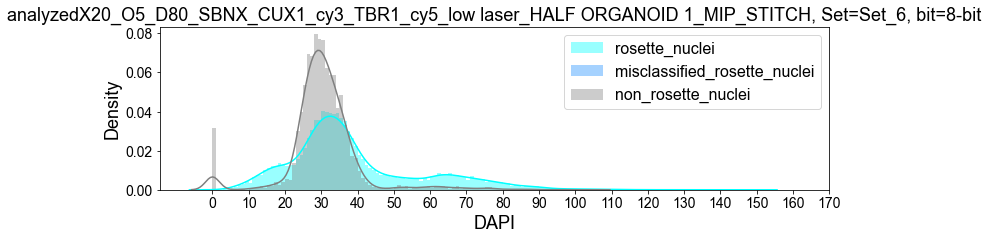

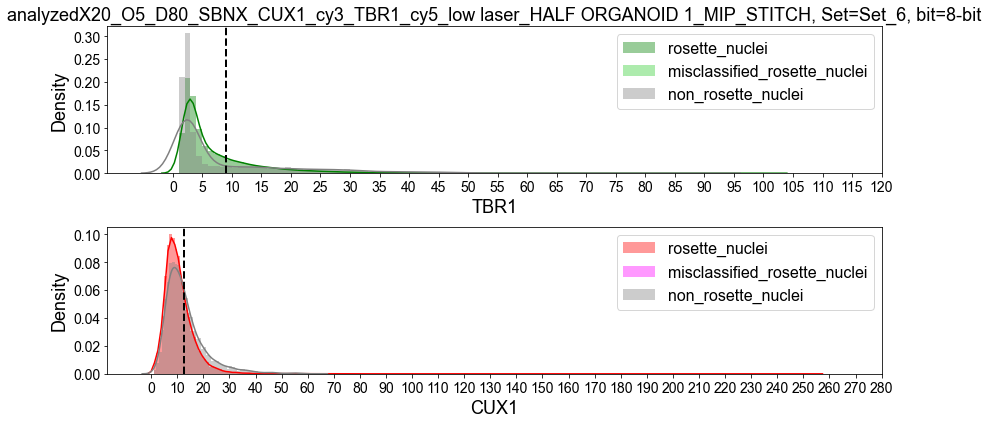

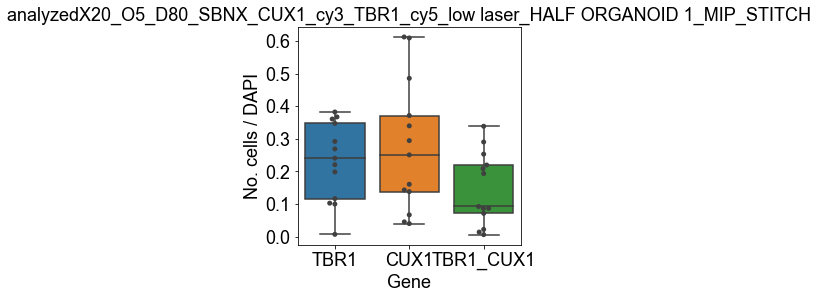

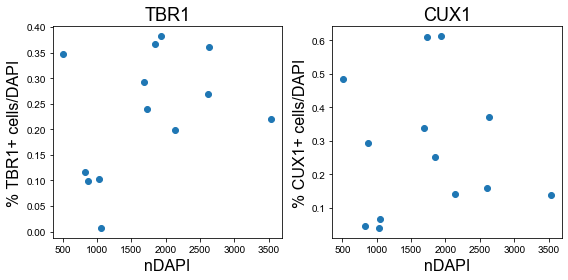

analyzedX20_O5_D80_SBN_CUX1_cy3_TBR1_cy5_low laser_HALF ORGANOID 1_MIP_STITCH


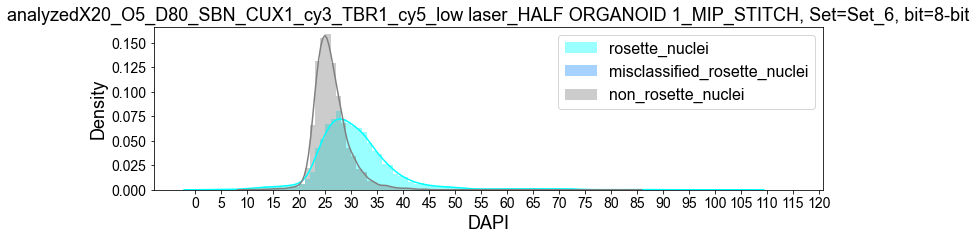

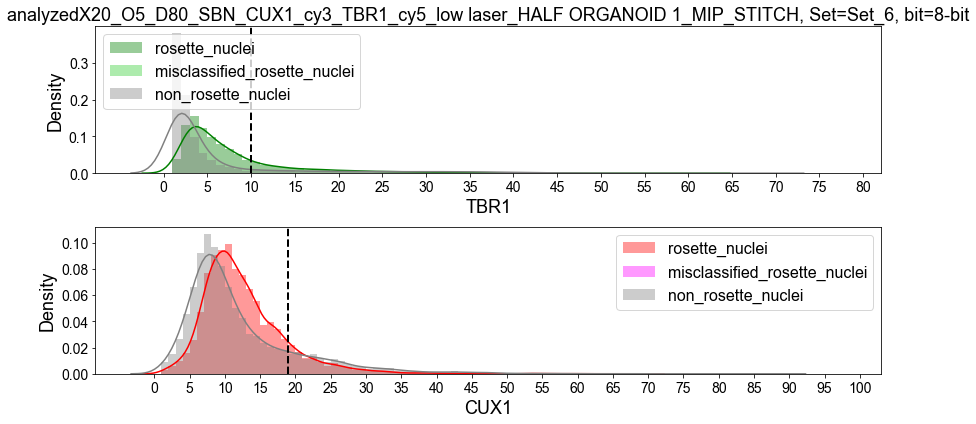

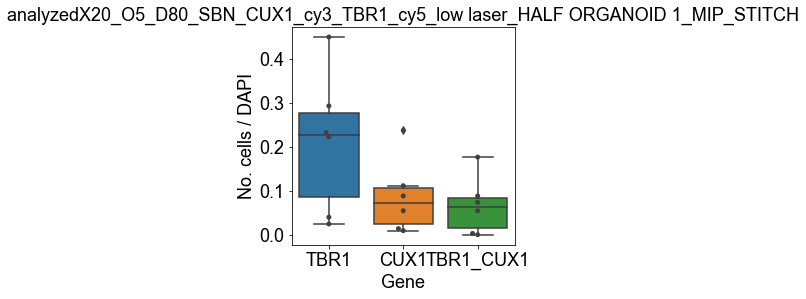

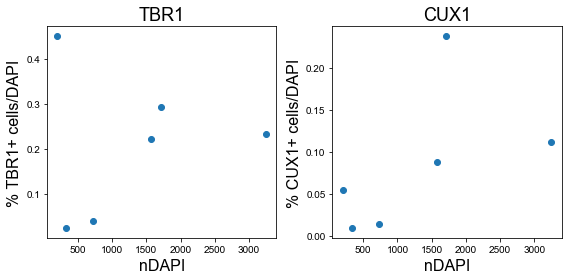

analyzedX20_O5_D80_SBNX_CUX1_cy3_TBR1_cy5_low laser_HALF ORGANOID 2_MIP_STITCH


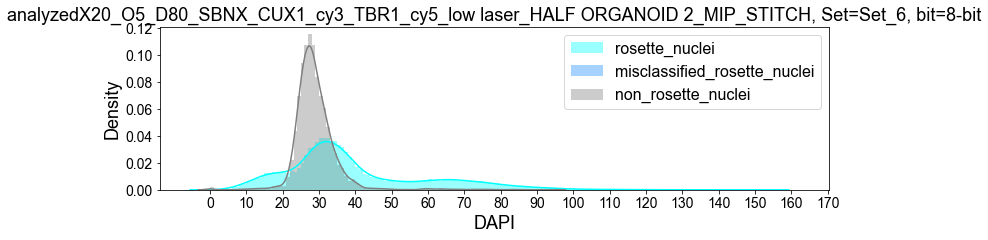

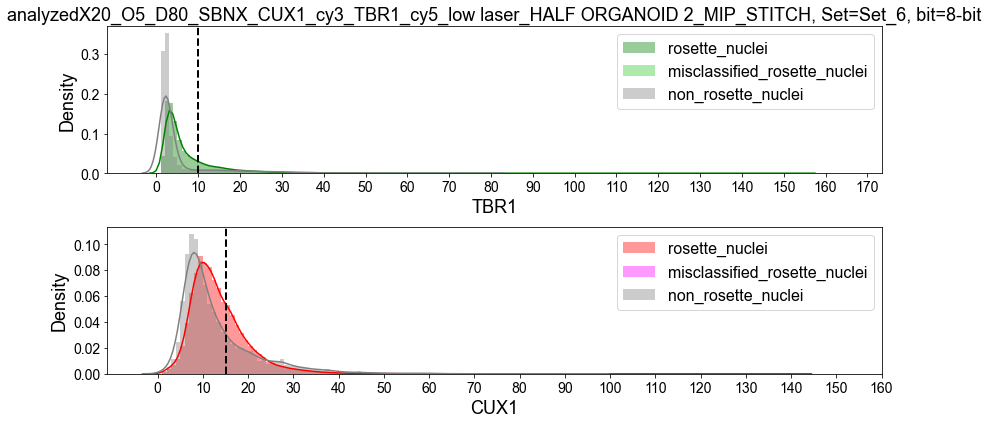

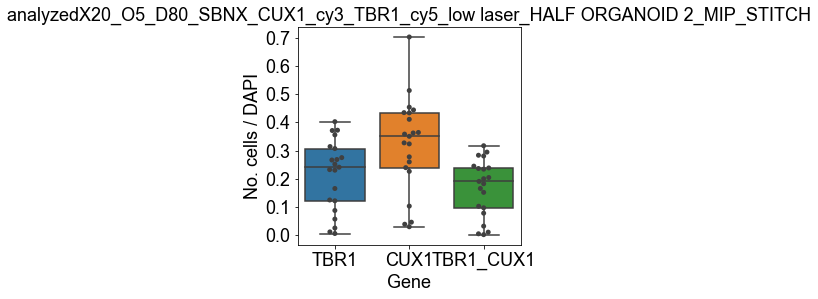

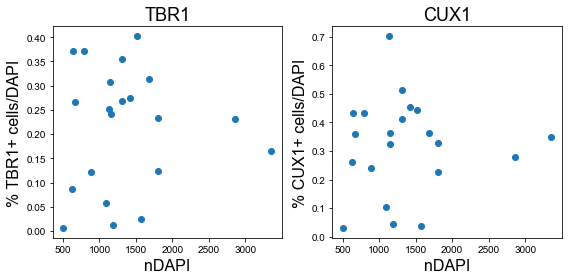

analyzedX20_O5_D80_SBN_CUX1_cy3_TBR1_cy5_low laser_HALF ORGANOID 2_MIP_STITCH


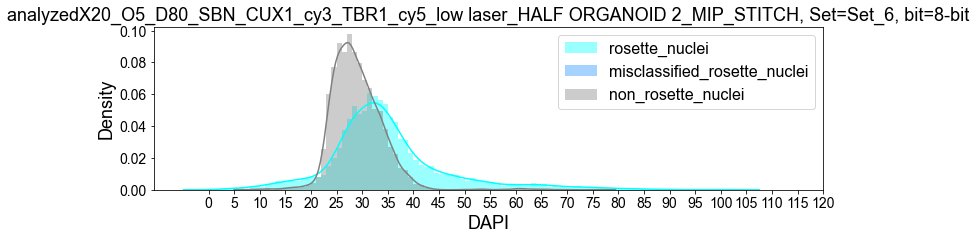

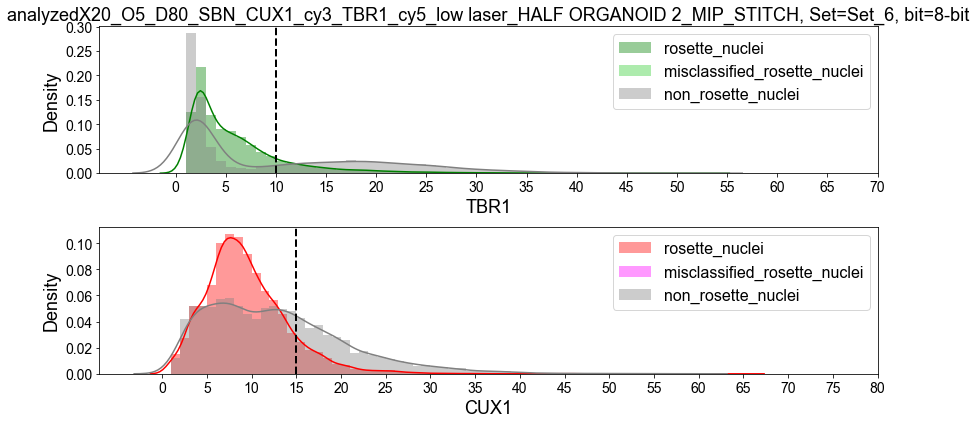

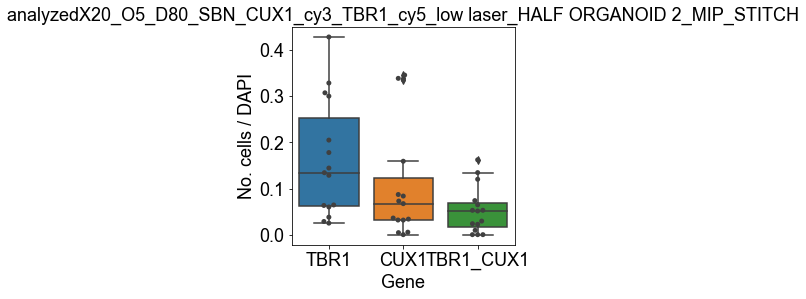

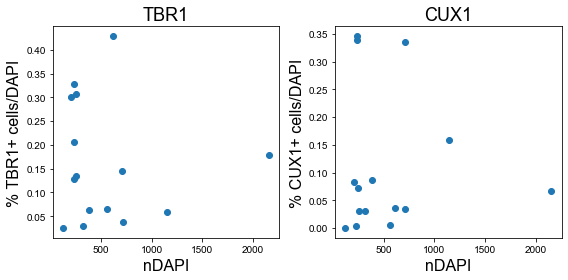

analyzedX20_O5_D80_SBN_SATB2_cy3_CTIP2_cy5_low laser_HALF ORGANOID 2_MIP_STITCH


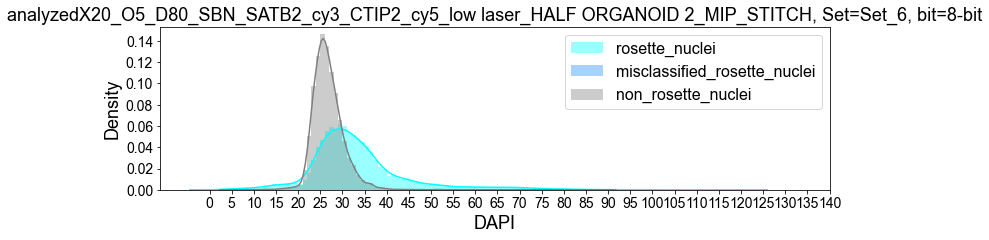

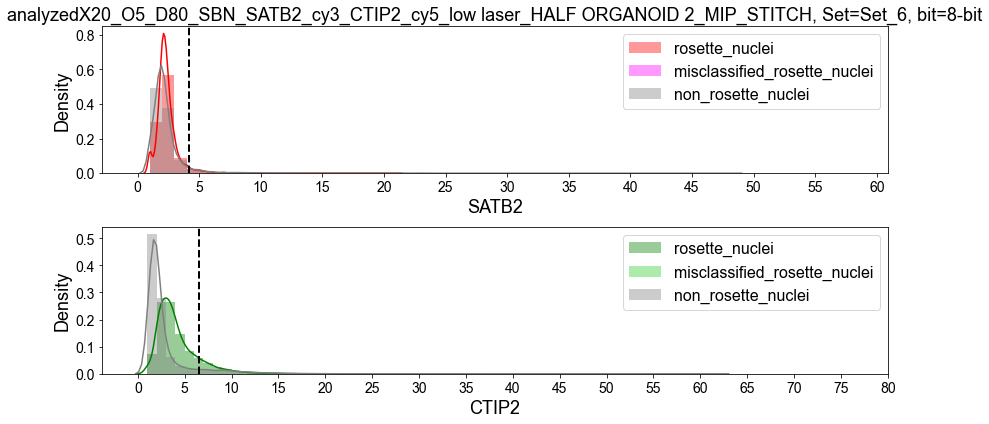

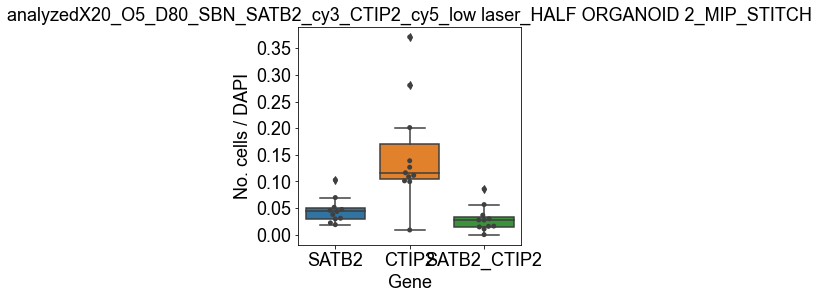

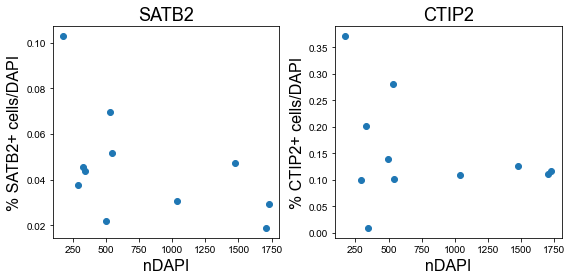

analyzedX20_O5_D80_SBNX_SATB2_cy3_CTIP2_cy5_low laser_HALF ORGANOID 2_MIP_STITCH


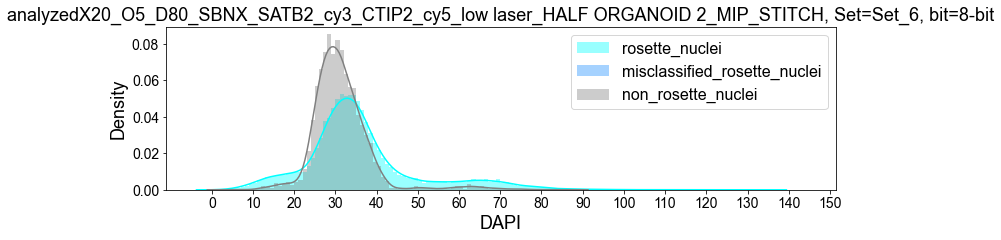

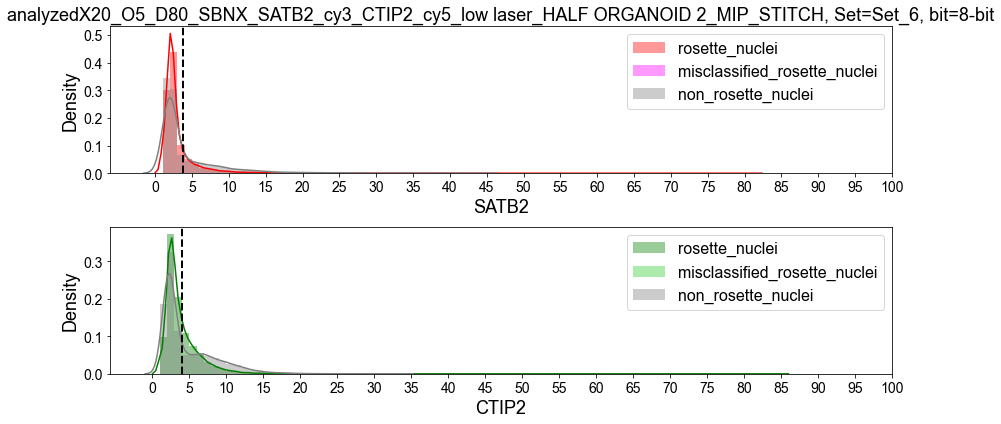

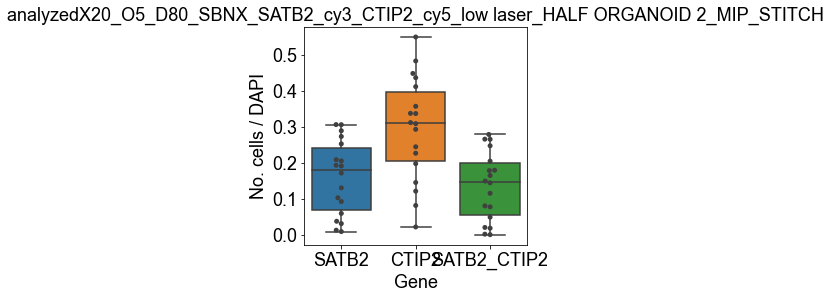

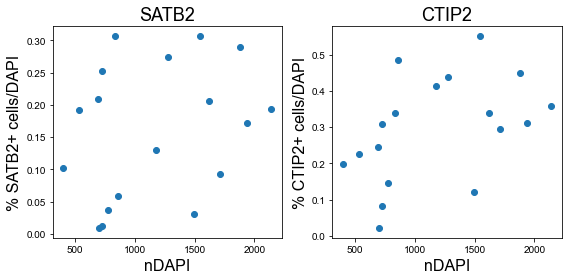

analyzedX20_O5_D80_SBN_SATB2_cy3_CTIP2_cy5_low laser_HALF ORGANOID 1_MIP_STITCH


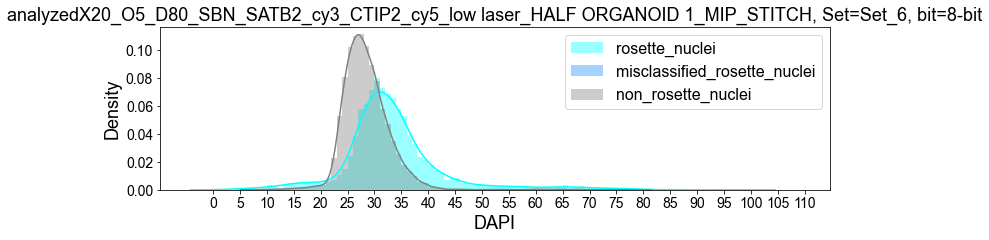

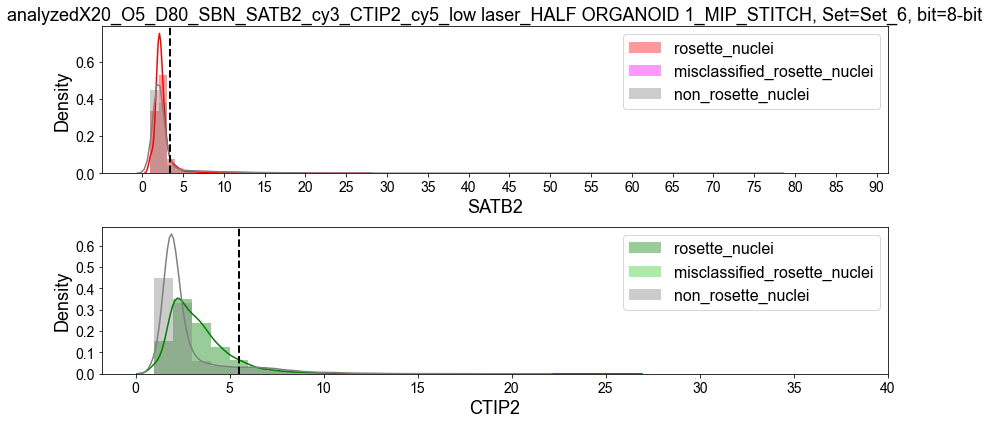

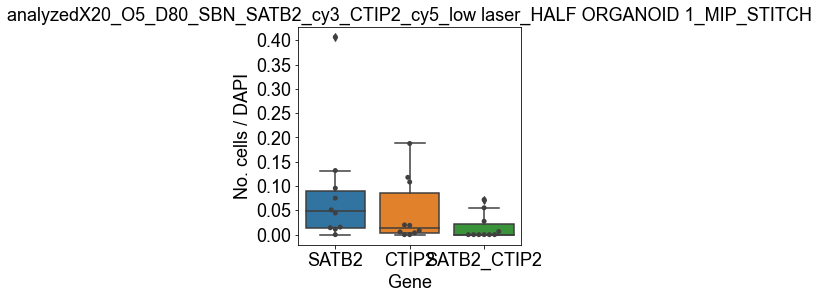

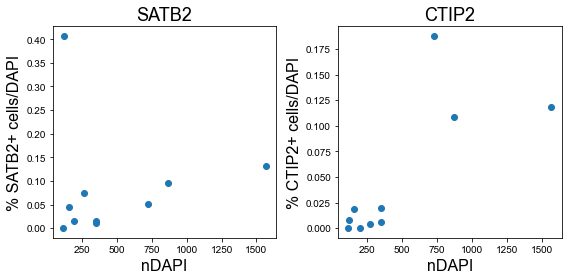

analyzedX20_O5_D80_SBNX_SATB2_cy3_CTIP2_cy5_low laser_HALF ORGANOID 1_MIP_STITCH


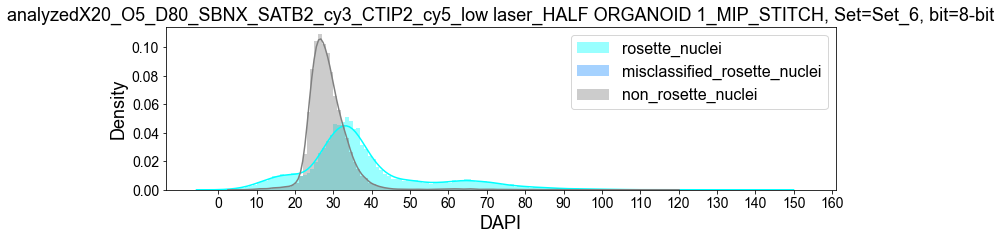

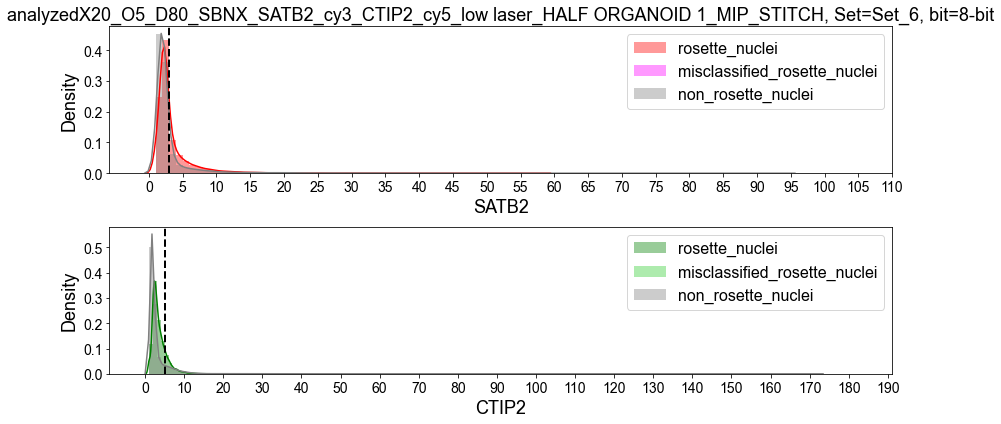

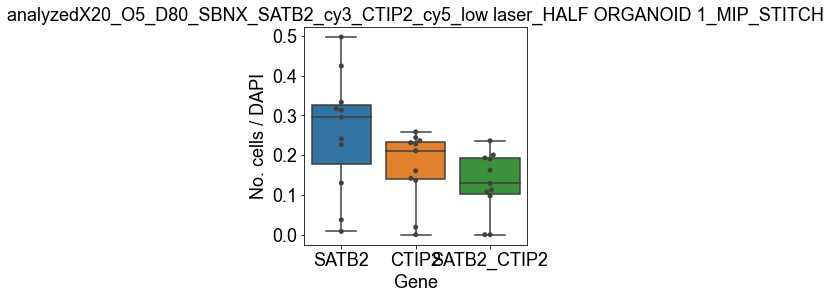

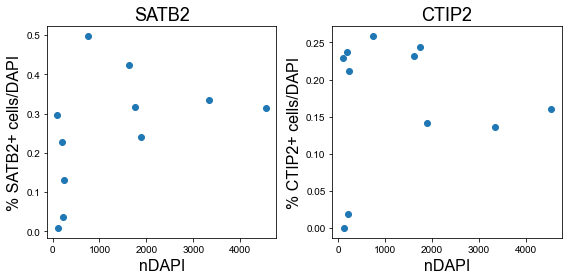

In [26]:
meta_dat = pd.read_csv('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/D80_countings_from_Rene/data/meta_data_rosette_objects_and_sets.tsv',sep='\t',index_col=0)

for gene1,gene2 in zip(['TBR1','SATB2'],
                       ['CUX1','CTIP2']):
    
    genes = [gene1,gene2]
    #if genes != ['PAX6','SP8']: continue
    for sample in list(set(meta_dat.index)):

        if gene1 not in sample:
            continue
        if gene2 not in sample:
            continue
        if 'HES5' in sample:
            continue

        gene_pair = frozenset([gene1,gene2])

        print(sample)
        df_dict = get_dataframes_from_samp(sample)
        rosette_id_map = build_rosette_id_mapping(df_dict)
        rosettes = []
        for rosette in rosette_id_map:
            rosettes.append([rosette])
        
        set_id = 'Set_6'
        rosette_mask_ids,tot_rosette_mask_ids,non_rosette_mask_ids = get_rosette_and_non_rosette_mask_ids(df_dict,rosettes,rosette_id_map)

        gene_channel_dict_r,gene_channel_dict,gene_color_dict = get_gene_to_color_map(set_id,sample)
        
        df_dict_rescaled,bit_value = reformat_dfs_with_8_bit(df_dict,rosettes,rosette_id_map,gene_channel_dict)
        
        # Plot DAPI #
        fig = plt.figure(figsize=(12,3))
        ax = plt.subplot(111)
        fig = plot_histogram_channel('DAPI',gene_channel_dict,df_dict_rescaled,tot_rosette_mask_ids,non_rosette_mask_ids,\
                                         set_id,gene_color_dict,bit_value,fig,ax)
        plt.show()
        
        df_dict,df_dict_rescaled = filter_cells_by_DAPI(df_dict,df_dict_rescaled,DAPI_cutoff=15)

        ### Remove Rosettes with small numbers of cells ###
        df_dict,df_dict_rescaled,rosette_mask_ids = filter_rosettes(df_dict,df_dict_rescaled,rosette_mask_ids,
                                                                    n_cells_cutoff=100) 

        fig = plt.figure(figsize=(12,6))
        pos_negs_ids_per_gene = {}
        for j,gene in enumerate(genes):
            ax = plt.subplot(2,1,j+1)
            intensity_cutoff = gene_intensity_cutoff_dict[sample][gene]
            fig = plot_histogram_channel(gene,gene_channel_dict,df_dict_rescaled,tot_rosette_mask_ids,non_rosette_mask_ids,\
                                         set_id,gene_color_dict,bit_value,fig,ax)
            plt.axvline(intensity_cutoff,linestyle='--',linewidth=2,color='black')
            pos_ids_per_rosette,neg_ids_per_rosette,pos_ids_mistaken_rosettes,\
            neg_ids_mistaken_rosettes,pos_ids_non_rosette,neg_ids_non_rosette = \
            get_pos_neg_cells_per_rosette(gene,gene_channel_dict,df_dict_rescaled,tot_rosette_mask_ids,non_rosette_mask_ids,\
                                          intensity_cutoff)       
            pos_negs_ids_per_gene[gene] = [pos_ids_per_rosette,neg_ids_per_rosette,pos_ids_mistaken_rosettes,\
            neg_ids_mistaken_rosettes,pos_ids_non_rosette,neg_ids_non_rosette]
            if j != 0:
                plt.title('')
        
        plt.tight_layout()
        plt.show()
        df_for_plotting = generate_df_for_plotting(pos_negs_ids_per_gene,genes,sample)
        agg_df = pd.concat([agg_df,df_for_plotting])
        df_non_rosettes = generate_df_non_rosettes(pos_negs_ids_per_gene,genes,sample)
        agg_df = pd.concat([agg_df,df_non_rosettes])
        fig = plt.figure(figsize=(4,4))
        ax = plt.subplot(111)
        fig = plot_comparisons_double_positives(df_for_plotting,sample,fig,ax)
        plt.show()

        fig = plt.figure(figsize=(8,4))
        for j,gene in enumerate(genes):
            ax = plt.subplot(1,2,j+1)
            df_gene = df_for_plotting[df_for_plotting['gene']==gene]
            plt.scatter(df_gene['n_DAPI'],df_gene['n_pos']/df_gene['n_DAPI'])
            plt.title(gene,fontsize=18)
            plt.xlabel('nDAPI',fontsize=16)
            plt.ylabel('% '+gene+'+ cells/DAPI',fontsize=16)
        
        plt.tight_layout()
        plt.show()

In [27]:
new_exp = []
rosette_number = []
rosette_iter = 1
added_samps = {}
tx_map_r = {'Dual SMAD-i':'SBN','Triple-i':'SBNX','Inhibitor-free':'NT'}
for j,(experiment,gene,type_,protocol,sample) in enumerate(zip(agg_df['experiment'],agg_df['gene'],agg_df['type'],agg_df['protocol'],agg_df['sample'])):
    if experiment not in added_samps:
        added_samps[experiment] = {}
    if protocol not in added_samps[experiment]:
        added_samps[experiment][protocol] = []
    if sample not in added_samps[experiment][protocol]:
        added_samps[experiment][protocol].append(sample)
        exp_iter = len(added_samps[experiment][protocol])
    if j == 0:
        rosette_number.append(rosette_iter)
        prev_ = [experiment,gene,protocol]
        new_exp.append(tx_map_r[protocol]+"_"+experiment+"_"+str(exp_iter))
        rosette_iter += 1
        continue
    if type_ != 'rosette':
        rosette_number.append('na')
        new_exp.append(tx_map_r[protocol]+"_"+experiment+"_"+str(exp_iter))
        rosette_iter = 1
    else:
        if [experiment,gene,protocol] == prev_:
            rosette_number.append(rosette_iter)
            new_exp.append(tx_map_r[protocol]+"_"+experiment+"_"+str(exp_iter))
            rosette_iter += 1
        elif experiment == prev_[0] and protocol == prev_[2]:
            rosette_iter = 1
            rosette_number.append(rosette_iter)
            new_exp.append(tx_map_r[protocol]+"_"+experiment+"_"+str(exp_iter))
            rosette_iter += 1
        elif experiment == prev_[0]:
            rosette_iter = 1
            rosette_number.append(rosette_iter)
            new_exp.append(tx_map_r[protocol]+"_"+experiment+"_"+str(exp_iter))
            rosette_iter += 1
        else:
            rosette_iter = 1
            rosette_number.append(rosette_iter)
            new_exp.append(tx_map_r[protocol]+"_"+experiment+"_"+str(exp_iter))
            rosette_iter += 1
        prev_ = [experiment,gene,protocol]

In [28]:
agg_df['new_sample'] = new_exp
agg_df['rosette_number'] = rosette_number

In [29]:
agg_df

,experiment,n_DAPI,gene,n_pos,percent_pos,sample,protocol,type,new_sample,rosette_number
0,CUX1_TBR1,1034.0,TBR1,106.0,0.102515,analyzedX20_O5_D80_SBNX_CUX1_cy3_TBR1_cy5_low ...,Triple-i,rosette,SBNX_CUX1_TBR1_1,1
1,CUX1_TBR1,2611.0,TBR1,703.0,0.269245,analyzedX20_O5_D80_SBNX_CUX1_cy3_TBR1_cy5_low ...,Triple-i,rosette,SBNX_CUX1_TBR1_1,2
2,CUX1_TBR1,1939.0,TBR1,742.0,0.382671,analyzedX20_O5_D80_SBNX_CUX1_cy3_TBR1_cy5_low ...,Triple-i,rosette,SBNX_CUX1_TBR1_1,3
3,CUX1_TBR1,1729.0,TBR1,416.0,0.240602,analyzedX20_O5_D80_SBNX_CUX1_cy3_TBR1_cy5_low ...,Triple-i,rosette,SBNX_CUX1_TBR1_1,4
4,CUX1_TBR1,506.0,TBR1,176.0,0.347826,analyzedX20_O5_D80_SBNX_CUX1_cy3_TBR1_cy5_low ...,Triple-i,rosette,SBNX_CUX1_TBR1_1,5
...,...,...,...,...,...,...,...,...,...,...
1,CTIP2_SATB2,23567.0,SATB2,4319.0,0.183265,analyzedX20_O5_D80_SBNX_SATB2_cy3_CTIP2_cy5_lo...,Triple-i,non-rosette,SBNX_CTIP2_SATB2_2,na
2,CTIP2_SATB2,0.0,CTIP2,0.0,NaN,analyzedX20_O5_D80_SBNX_SATB2_cy3_CTIP2_cy5_lo...,Triple-i,mistaken rosette,SBNX_CTIP2_SATB2_2,na
3,CTIP2_SATB2,23567.0,CTIP2,2790.0,0.118386,analyzedX20_O5_D80_SBNX_SATB2_cy3_CTIP2_cy5_lo...,Triple-i,non-rosette,SBNX_CTIP2_SATB2_2,na
4,CTIP2_SATB2,0.0,SATB2_CTIP2,0.0,NaN,analyzedX20_O5_D80_SBNX_SATB2_cy3_CTIP2_cy5_lo...,Triple-i,mistaken rosette,SBNX_CTIP2_SATB2_2,na


In [30]:
agg_df.to_csv('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/D80_countings_from_Rene/agg_data.tsv',sep='\t',index=False)

In [31]:
agg_df_dict_pvals = {'experiment':[],'comparison':[],'gene':[],'pval':[],'pval_adj':[],'star_pval':[],'star_pval_adj':[]}
agg_df_pvals = pd.DataFrame(agg_df_dict_pvals)
pval_dict_full = {}
pval_dict_full_2 = {}

In [32]:
for exp in set(agg_df['experiment']):
    if exp not in pval_dict_full_2: pval_dict_full_2[exp] = {}
    for gene in set(agg_df[agg_df['experiment']==exp]['gene']):
        pval_dict = {}
        n_dapi_sbn = sum(agg_df[(agg_df['experiment']==exp) & (agg_df['gene']==gene) & (agg_df['protocol']=='Dual SMAD-i') & (agg_df['type']=='non-rosette')]['n_DAPI'])
        n_dapi_sbnx = sum(agg_df[(agg_df['experiment']==exp) & (agg_df['gene']==gene) & (agg_df['protocol']=='Triple-i') & (agg_df['type']=='non-rosette')]['n_DAPI'])
        n_pos_sbn = sum(agg_df[(agg_df['experiment']==exp) & (agg_df['gene']==gene) & (agg_df['protocol']=='Dual SMAD-i') & (agg_df['type']=='non-rosette')]['n_pos'])
        n_pos_sbnx = sum(agg_df[(agg_df['experiment']==exp) & (agg_df['gene']==gene) & (agg_df['protocol']=='Triple-i') & (agg_df['type']=='non-rosette')]['n_pos'])
        table = [[n_pos_sbn,n_pos_sbnx],[n_dapi_sbn-n_pos_sbn,n_dapi_sbnx-n_pos_sbnx]]
        fisher_exact_pval = fisher_exact(table, alternative='two-sided')[1]
        print(exp,gene,table,fisher_exact_pval)
        pval_dict_full_2[exp][gene+'.Dual SMAD-i_Triple-i'] = fisher_exact_pval

CTIP2_SATB2 SATB2_CTIP2 [[1929.0, 3696.0], [27518.0, 24777.0]] 2.045008525355475e-152
CTIP2_SATB2 CTIP2 [[2868.0, 4643.0], [26579.0, 23830.0]] 4.881666882728462e-123
CTIP2_SATB2 SATB2 [[3287.0, 5770.0], [26160.0, 22703.0]] 1.6220227011996152e-201
CUX1_TBR1 CUX1 [[3075.0, 3340.0], [9356.0, 7169.0]] 3.01161153742633e-32
CUX1_TBR1 TBR1_CUX1 [[2336.0, 1848.0], [10095.0, 8661.0]] 0.018739688680338422
CUX1_TBR1 TBR1 [[3608.0, 2114.0], [8823.0, 8395.0]] 6.605698501504459e-55


In [33]:
df_sub_exp

NameError: name 'df_sub_exp' is not defined

SATB2 Dual SMAD-i Triple-i 0.00017714104341516392 ***
CTIP2 Dual SMAD-i Triple-i 0.0001538669535306298 ***
SATB2_CTIP2 Dual SMAD-i Triple-i 1.0627729043570966e-06 ****
SATB2_CTIP2 0.06550752198865759
SATB2_CTIP2 0.12980718575492572
CUX1 Dual SMAD-i Triple-i 3.279515881570227e-05 ****
TBR1 Dual SMAD-i Triple-i 0.2150585363909032 n.s.
TBR1_CUX1 Dual SMAD-i Triple-i 0.00010384503831936091 ***
TBR1_CUX1 0.18791730351540503
TBR1_CUX1 0.1758492720525264


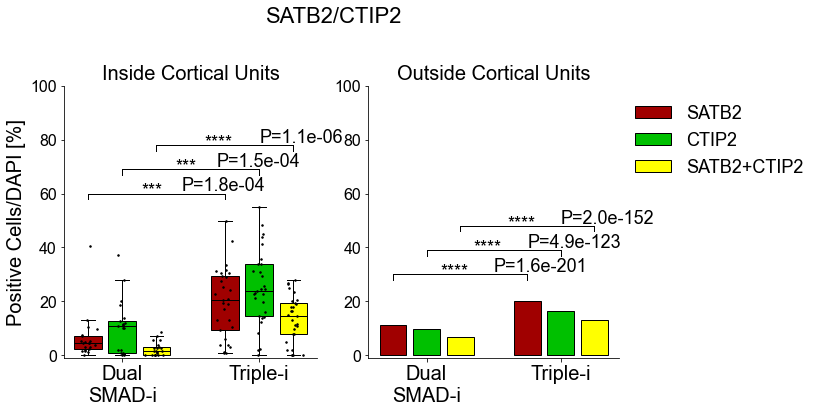

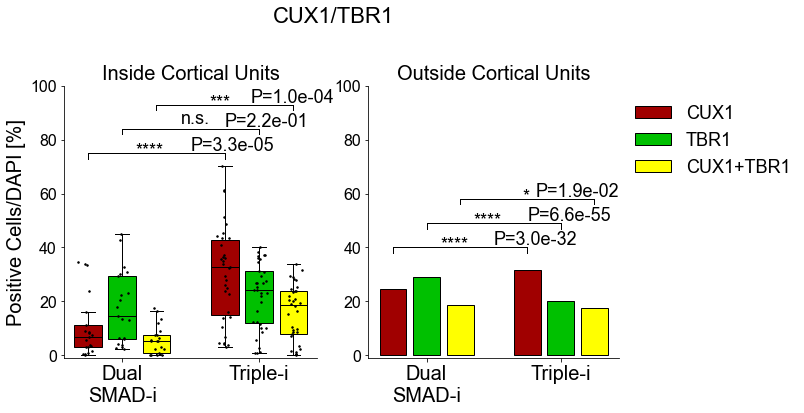

In [34]:
# 1. make aggregate SBNX, SBN, NT box plots
# 2. plot bar plots for cells in mistaken and non-rosettes

colors_full = [(160/255.,0,0),(0,192/255.,0),(255/255.,255/255.,0)]

for genes in [['SATB2','CTIP2'],['CUX1','TBR1']]:
    
    #if genes != ['PAX6','SP8']: continue
    # first plot rosettes
    experiment = '_'.join(sorted(genes))
    df_sub = agg_df[(agg_df['experiment'] == experiment) & (agg_df['type'] == 'rosette')]
    vals = []
    positions = []
    colors = []
    pos_iter = 0
    n_tx = {}
    pval_dict = {}
    
    for j,tx in enumerate(['Dual SMAD-i','Triple-i']):
        
        df_sub_exp = df_sub[df_sub['protocol']==tx]
        n_tx[tx] = len(set(df_sub_exp['sample']))
        for k,gene in enumerate(genes):
            df_sub_exp_gene = df_sub_exp[df_sub_exp['gene']==gene]
            vals.append(list(df_sub_exp_gene['percent_pos']))
            positions.append(pos_iter)
            colors.append(colors_full[k])
            pos_iter += 1

        if 'SATB2' in genes:
            gene_combo = genes[0]+"_"+genes[1]
        else:
            gene_combo = genes[1]+"_"+genes[0]
        df_sub_exp_gene = df_sub_exp[df_sub_exp['gene']==gene_combo]
        vals.append(list(df_sub_exp_gene['percent_pos']))
        positions.append(pos_iter)
        colors.append(colors_full[k+1])
        pos_iter += 1
        # double and triple combos
        pos_iter+=1
    
    ### t-tests for difference  in means ###
    for j,tx_comp in enumerate([['Dual SMAD-i','Triple-i']]):
        
        df_sub_exp = df_sub[df_sub['protocol'].isin([tx_comp[0],tx_comp[1]])]
        n_tx[tx] = len(set(df_sub_exp['sample']))
        for k,gene in enumerate(genes):
            vals1 = list(df_sub[(df_sub['protocol']==tx_comp[0]) & (df_sub['gene']==gene)]['percent_pos'])
            vals2 = list(df_sub[(df_sub['protocol']==tx_comp[1]) & (df_sub['gene']==gene)]['percent_pos'])
            t, p = ttest(vals1, vals2,alternative='two.sided')#,alternative='less')
            if p < 0.0001: star_t = '****'
            elif p < 0.001: star_t = '***'
            elif p < 0.01: star_t = '**'
            elif p < 0.05: star_t = '*'
            else: star_t = 'n.s.'
            print(gene, tx_comp[0], tx_comp[1], p, star_t)
            pval_dict[gene+'.'+tx_comp[0]+'_'+tx_comp[1]] = p
        
        if 'SATB2' in genes:
            gene_combo = genes[0]+"_"+genes[1]
        else:
            gene_combo = genes[1]+"_"+genes[0]
        vals1 = list(df_sub[(df_sub['protocol']==tx_comp[0]) & (df_sub['gene']==gene_combo)]['percent_pos'])
        vals2 = list(df_sub[(df_sub['protocol']==tx_comp[1]) & (df_sub['gene']==gene_combo)]['percent_pos'])
        t, p = ttest(vals1, vals2,alternative='two.sided')#,alternative='less')
        if p < 0.0001: star_t = '****'
        elif p < 0.001: star_t = '***'
        elif p < 0.01: star_t = '**'
        elif p < 0.05: star_t = '*'
        else: star_t = 'n.s.'
        print(gene_combo, tx_comp[0], tx_comp[1], p, star_t)
        pval_dict[gene_combo+'.'+tx_comp[0]+'_'+tx_comp[1]] = p
    
    pval_dict_full[experiment] = pval_dict
    fig = plt.figure(figsize=(10,5))
    ax = plt.subplot(121)

    bp = ax.boxplot(vals,positions=positions,showfliers=False,vert=True, patch_artist=True,zorder=1,widths=0.8)
    for j,patch in enumerate(bp['boxes']):
        patch.set_facecolor(color=colors[j])
    for j,whisker in enumerate(bp['whiskers']):
        whisker.set(color='black', linewidth=1)
    for j,cap in enumerate(bp['caps']):
        cap.set(color='black', linewidth=1)
    for j,median in enumerate(bp['means']):
        median.set(color='black', linewidth=1)
    for j,median in enumerate(bp['medians']):
        median.set(color='black', linewidth=1)

    for val,pos,col in zip(vals,positions,colors):
        plt.plot([pos]*len(val)+np.random.randn(len(val))*0.1,val,'.',markersize=3,color='black',
                 zorder=2,alpha=1)#markerfacecolor='none',
    
    if 'SATB2' in genes: 
        stars_ = ['***','***','****']
        pvals__ = [pval_dict_full['CTIP2_SATB2']['SATB2.Dual SMAD-i_Triple-i'],
                   pval_dict_full['CTIP2_SATB2']['CTIP2.Dual SMAD-i_Triple-i'],
                   pval_dict_full['CTIP2_SATB2']['SATB2_CTIP2.Dual SMAD-i_Triple-i']]
        y_new = 0.6
    else:
        stars_ = ['****','n.s.','***']
        pvals__ = [pval_dict_full['CUX1_TBR1']['CUX1.Dual SMAD-i_Triple-i'],
                   pval_dict_full['CUX1_TBR1']['TBR1.Dual SMAD-i_Triple-i'],
                   pval_dict_full['CUX1_TBR1']['TBR1_CUX1.Dual SMAD-i_Triple-i']]
        y_new = 0.75
    for y,annot_,pp in zip([[0,4],[1,5],[2,6]],stars_,pvals__):
        plt.plot([y[0],y[1]],[y_new,y_new],'-',color='black',linewidth=1)
        plt.plot([y[0],y[0]],[y_new-0.02,y_new],'-',color='black',linewidth=1)
        plt.plot([y[1],y[1]],[y_new-0.02,y_new],'-',color='black',linewidth=1)
        if '*' in annot_:
            plt.annotate(annot_,xy=(y[0]+(y[1]-y[0])/2.-len(annot_)*0.15,y_new-0.01),fontsize=18)
            plt.annotate('P='+"{:.1e}".format(pp),xy=(y[0]+(y[1]-y[0])/2.+len(annot_)*0.25,y_new+0.01),fontsize=18)
        else:
            plt.annotate(annot_,xy=(y[0]+(y[1]-y[0])/2.-len(annot_)*0.07,y_new+0.02),fontsize=18)
            plt.annotate('P='+"{:.1e}".format(pp),xy=(y[0]+(y[1]-y[0])/2.+len(annot_)*0.25,y_new+0.01),fontsize=18)
        y_new += 0.09

    plt.xlim(plt.xlim()[0]-0.2,plt.xlim()[1]+0.2)
    #plt.xticks([1,5,9],[tx+'\n(N='+str(n_tx[tx])+')' for tx in ['Inhibitor-free','Dual-SMAD-i','Triple-i']],fontsize=18)
    plt.xticks([1,5],['Dual\nSMAD-i','Triple-i'],fontsize=20)
    plt.ylabel('Positive Cells/DAPI [%]',fontsize=20)
    plt.title('Inside Cortical Units',fontsize=20)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.yticks([0,0.2,0.4,0.6,0.8,1],[str(int(x*100)) for x in [0,0.2,0.4,0.6,0.8,1]],fontsize=16)
    plt.ylim(-0.01,1)
    ax = plt.subplot(122)
    experiment = '_'.join(sorted(genes))
    df_sub = agg_df[(agg_df['experiment'] == experiment) & (agg_df['type']!='rosette')]
    pos_iter = 0
    for j,tx in enumerate(['Dual SMAD-i','Triple-i']):
        
        df_sub_exp = df_sub[df_sub['protocol']==tx]
        for k,gene in enumerate(genes):
            
            non_rosettes = np.sum(list(df_sub_exp[(df_sub_exp['type']=='non-rosette') & (df_sub_exp['gene']==gene)]['n_pos']))/np.sum(list(df_sub_exp[(df_sub_exp['type']=='non-rosette') & (df_sub_exp['gene']==gene_combo)]['n_DAPI']))
            plt.bar(pos_iter,non_rosettes,color=colors_full[k],edgecolor='black')
            #plt.plot([pos_iter for ii in range(len(non_rosettes))],non_rosettes,'.',markersize=5,color='black',
            #     zorder=2,alpha=1)#markerfacecolor='none',
            #plt.plot([pos_iter,pos_iter],[min(non_rosettes),max(non_rosettes)],'-',linewidth=1,color='black',
            # zorder=2,alpha=1)#markerfacecolor='none',
            pos_iter += 1
            
        if 'SATB2' in genes:
            gene_combo = genes[0]+"_"+genes[1]
        else:
            gene_combo = genes[1]+"_"+genes[0]
        
        non_rosettes = np.sum(list(df_sub_exp[(df_sub_exp['type']=='non-rosette') & (df_sub_exp['gene']==gene_combo)]['n_pos']))/np.sum(list(df_sub_exp[(df_sub_exp['type']=='non-rosette') & (df_sub_exp['gene']==gene_combo)]['n_DAPI']))
        print(gene_combo,non_rosettes)
        plt.bar(pos_iter,non_rosettes,color=colors_full[k+1],edgecolor='black')
        #plt.plot([pos_iter for ii in range(len(non_rosettes))],non_rosettes,'.',markersize=5,color='black',
        #     zorder=2,alpha=1)#markerfacecolor='none',
        #plt.plot([pos_iter,pos_iter],[min(non_rosettes),max(non_rosettes)],'-',linewidth=1,color='black',
        #     zorder=2,alpha=1)#markerfacecolor='none',
        pos_iter += 1
        
        df_sub_exp_gene = df_sub_exp[df_sub_exp['gene']==gene_combo]
        vals.append(list(df_sub_exp_gene['percent_pos']))
        positions.append(pos_iter)
        colors.append(colors_full[k+1])
        pos_iter += 1
        # double and triple combos
    
    plt.xticks([1,5],['Dual\nSMAD-i','Triple-i'],fontsize=20)
    plt.xlim(plt.xlim())
    plt.ylim(-0.01,1)
    plt.yticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.yticks([0,0.2,0.4,0.6,0.8,1],[str(int(x*100)) for x in [0,0.2,0.4,0.6,0.8,1]],fontsize=16)
    #ax.spines["left"].set_visible(False)
    #plt.tight_layout()
    
    if 'SATB2' in genes: 
        stars_ = ['****','****','****']
        pvals__ = [pval_dict_full_2['CTIP2_SATB2']['SATB2.Dual SMAD-i_Triple-i'],
                   pval_dict_full_2['CTIP2_SATB2']['CTIP2.Dual SMAD-i_Triple-i'],
                   pval_dict_full_2['CTIP2_SATB2']['SATB2_CTIP2.Dual SMAD-i_Triple-i']]
        y_new = 0.3
    else:
        stars_ = ['****','****','*']
        pvals__ = [pval_dict_full_2['CUX1_TBR1']['CUX1.Dual SMAD-i_Triple-i'],
                   pval_dict_full_2['CUX1_TBR1']['TBR1.Dual SMAD-i_Triple-i'],
                   pval_dict_full_2['CUX1_TBR1']['TBR1_CUX1.Dual SMAD-i_Triple-i']]
        y_new = 0.4
    for y,annot_,pp in zip([[0,4],[1,5],[2,6]],stars_,pvals__):
        plt.plot([y[0],y[1]],[y_new,y_new],'-',color='black',linewidth=1)
        plt.plot([y[0],y[0]],[y_new-0.02,y_new],'-',color='black',linewidth=1)
        plt.plot([y[1],y[1]],[y_new-0.02,y_new],'-',color='black',linewidth=1)
        if '*' in annot_:
            plt.annotate(annot_,xy=(y[0]+(y[1]-y[0])/2.-len(annot_)*0.15,y_new-0.01),fontsize=18)
            plt.annotate('P='+"{:.1e}".format(pp),xy=(y[0]+(y[1]-y[0])/2.+len(annot_)*0.25,y_new+0.01),fontsize=18)
        else:
            plt.annotate(annot_,xy=(y[0]+(y[1]-y[0])/2.-len(annot_)*0.07,y_new+0.02),fontsize=18)
            plt.annotate('P='+"{:.1e}".format(pp),xy=(y[0]+(y[1]-y[0])/2.+len(annot_)*0.25,y_new+0.01),fontsize=18)
        y_new += 0.09
    
    for k,gene in enumerate(genes):
        plt.bar(-10,0,color=colors_full[k],label=gene,edgecolor='black')
    plt.bar(-10,0,color=colors_full[k+1],label=genes[0]+"+"+genes[1],edgecolor='black')
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.99, box.height])
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.8),fontsize=18,frameon=False)
    plt.title('Outside Cortical Units',fontsize=20)
    plt.suptitle('/'.join(genes),fontsize=22,y=1.1)
    plt.savefig('figures/fig7/'+experiment+'.png',dpi=500,bbox_inches='tight')
    plt.savefig('figures/fig7/'+experiment+'.pdf')

SATB2 Dual SMAD-i Triple-i 0.00017714104341516528 ***
CTIP2 Dual SMAD-i Triple-i 0.00015386695353063095 ***
SATB2_CTIP2 Dual SMAD-i Triple-i 1.0627729043570966e-06 ****
SATB2_CTIP2 0.06550752198865759
SATB2_CTIP2 0.12980718575492572
CUX1 Dual SMAD-i Triple-i 3.279515881570227e-05 ****
TBR1 Dual SMAD-i Triple-i 0.2150585363909032 n.s.
TBR1_CUX1 Dual SMAD-i Triple-i 0.00010384503831936091 ***
TBR1_CUX1 0.18791730351540503
TBR1_CUX1 0.1758492720525264


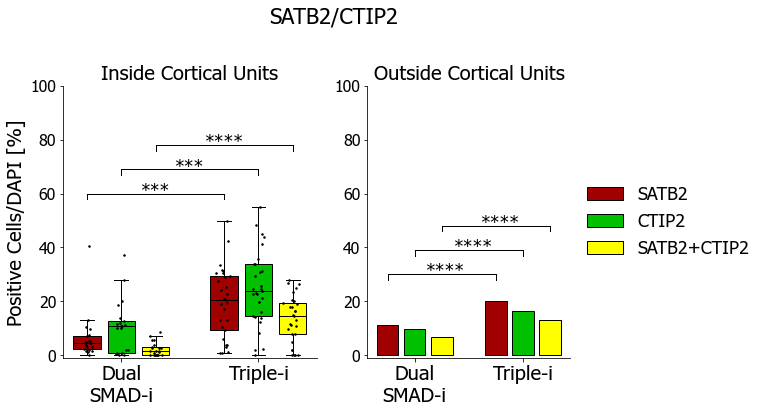

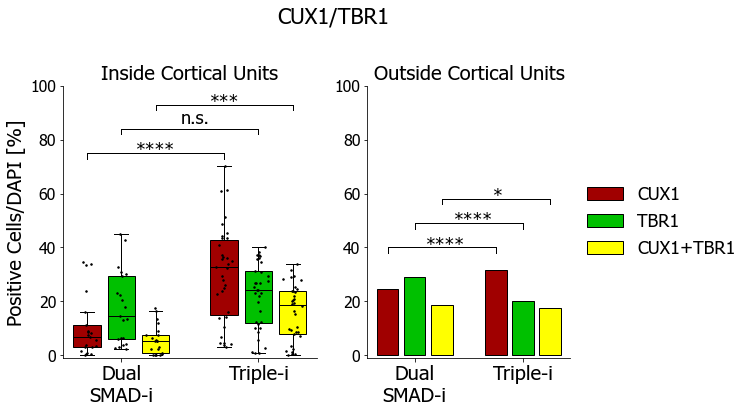

In [214]:
# 1. make aggregate SBNX, SBN, NT box plots
# 2. plot bar plots for cells in mistaken and non-rosettes

colors_full = [(160/255.,0,0),(0,192/255.,0),(255/255.,255/255.,0)]

for genes in [['SATB2','CTIP2'],['CUX1','TBR1']]:
    
    #if genes != ['PAX6','SP8']: continue
    # first plot rosettes
    experiment = '_'.join(sorted(genes))
    df_sub = agg_df[(agg_df['experiment'] == experiment) & (agg_df['type'] == 'rosette')]
    vals = []
    positions = []
    colors = []
    pos_iter = 0
    n_tx = {}
    pval_dict = {}
    
    for j,tx in enumerate(['Dual SMAD-i','Triple-i']):
        
        df_sub_exp = df_sub[df_sub['protocol']==tx]
        n_tx[tx] = len(set(df_sub_exp['sample']))
        for k,gene in enumerate(genes):
            df_sub_exp_gene = df_sub_exp[df_sub_exp['gene']==gene]
            vals.append(list(df_sub_exp_gene['percent_pos']))
            positions.append(pos_iter)
            colors.append(colors_full[k])
            pos_iter += 1

        if 'SATB2' in genes:
            gene_combo = genes[0]+"_"+genes[1]
        else:
            gene_combo = genes[1]+"_"+genes[0]
        df_sub_exp_gene = df_sub_exp[df_sub_exp['gene']==gene_combo]
        vals.append(list(df_sub_exp_gene['percent_pos']))
        positions.append(pos_iter)
        colors.append(colors_full[k+1])
        pos_iter += 1
        # double and triple combos
        pos_iter+=1
    
    ### t-tests for difference  in means ###
    for j,tx_comp in enumerate([['Dual SMAD-i','Triple-i']]):
        
        df_sub_exp = df_sub[df_sub['protocol'].isin([tx_comp[0],tx_comp[1]])]
        n_tx[tx] = len(set(df_sub_exp['sample']))
        for k,gene in enumerate(genes):
            vals1 = list(df_sub[(df_sub['protocol']==tx_comp[0]) & (df_sub['gene']==gene)]['percent_pos'])
            vals2 = list(df_sub[(df_sub['protocol']==tx_comp[1]) & (df_sub['gene']==gene)]['percent_pos'])
            t, p = ttest(vals1, vals2,alternative='two.sided')#,alternative='less')
            if p < 0.0001: star_t = '****'
            elif p < 0.001: star_t = '***'
            elif p < 0.01: star_t = '**'
            elif p < 0.05: star_t = '*'
            else: star_t = 'n.s.'
            print(gene, tx_comp[0], tx_comp[1], p, star_t)
            pval_dict[gene+'.'+tx_comp[0]+'_'+tx_comp[1]] = p
        
        if 'SATB2' in genes:
            gene_combo = genes[0]+"_"+genes[1]
        else:
            gene_combo = genes[1]+"_"+genes[0]
        vals1 = list(df_sub[(df_sub['protocol']==tx_comp[0]) & (df_sub['gene']==gene_combo)]['percent_pos'])
        vals2 = list(df_sub[(df_sub['protocol']==tx_comp[1]) & (df_sub['gene']==gene_combo)]['percent_pos'])
        t, p = ttest(vals1, vals2,alternative='two.sided')#,alternative='less')
        if p < 0.0001: star_t = '****'
        elif p < 0.001: star_t = '***'
        elif p < 0.01: star_t = '**'
        elif p < 0.05: star_t = '*'
        else: star_t = 'n.s.'
        print(gene_combo, tx_comp[0], tx_comp[1], p, star_t)
        pval_dict[gene_combo+'.'+tx_comp[0]+'_'+tx_comp[1]] = p
    
    pval_dict_full[experiment] = pval_dict
    fig = plt.figure(figsize=(10,5))
    ax = plt.subplot(121)

    bp = ax.boxplot(vals,positions=positions,showfliers=False,vert=True, patch_artist=True,zorder=1,widths=0.8)
    for j,patch in enumerate(bp['boxes']):
        patch.set_facecolor(color=colors[j])
    for j,whisker in enumerate(bp['whiskers']):
        whisker.set(color='black', linewidth=1)
    for j,cap in enumerate(bp['caps']):
        cap.set(color='black', linewidth=1)
    for j,median in enumerate(bp['means']):
        median.set(color='black', linewidth=1)
    for j,median in enumerate(bp['medians']):
        median.set(color='black', linewidth=1)

    for val,pos,col in zip(vals,positions,colors):
        plt.plot([pos]*len(val)+np.random.randn(len(val))*0.1,val,'.',markersize=3,color='black',
                 zorder=2,alpha=1)#markerfacecolor='none',
    
    if 'SATB2' in genes: 
        stars_ = ['***','***','****']
        y_new = 0.6
    else:
        stars_ = ['****','n.s.','***']
        y_new = 0.75
    for y,annot_ in zip([[0,4],[1,5],[2,6]],stars_):
        plt.plot([y[0],y[1]],[y_new,y_new],'-',color='black',linewidth=1)
        plt.plot([y[0],y[0]],[y_new-0.02,y_new],'-',color='black',linewidth=1)
        plt.plot([y[1],y[1]],[y_new-0.02,y_new],'-',color='black',linewidth=1)
        if '*' in annot_:
            plt.annotate(annot_,xy=(y[0]+(y[1]-y[0])/2.-len(annot_)*0.15,y_new-0.01),fontsize=18)
        else:
            plt.annotate(annot_,xy=(y[0]+(y[1]-y[0])/2.-len(annot_)*0.07,y_new+0.02),fontsize=18)
        y_new += 0.09

    plt.xlim(plt.xlim()[0]-0.2,plt.xlim()[1]+0.2)
    #plt.xticks([1,5,9],[tx+'\n(N='+str(n_tx[tx])+')' for tx in ['Inhibitor-free','Dual-SMAD-i','Triple-i']],fontsize=18)
    plt.xticks([1,5],['Dual\nSMAD-i','Triple-i'],fontsize=20)
    plt.ylabel('Positive Cells/DAPI [%]',fontsize=20)
    plt.title('Inside Cortical Units',fontsize=20)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.yticks([0,0.2,0.4,0.6,0.8,1],[str(int(x*100)) for x in [0,0.2,0.4,0.6,0.8,1]],fontsize=16)
    plt.ylim(-0.01,1)
    ax = plt.subplot(122)
    experiment = '_'.join(sorted(genes))
    df_sub = agg_df[(agg_df['experiment'] == experiment) & (agg_df['type']!='rosette')]
    pos_iter = 0
    for j,tx in enumerate(['Dual SMAD-i','Triple-i']):
        
        df_sub_exp = df_sub[df_sub['protocol']==tx]
        for k,gene in enumerate(genes):
            
            non_rosettes = np.sum(list(df_sub_exp[(df_sub_exp['type']=='non-rosette') & (df_sub_exp['gene']==gene)]['n_pos']))/np.sum(list(df_sub_exp[(df_sub_exp['type']=='non-rosette') & (df_sub_exp['gene']==gene_combo)]['n_DAPI']))
            plt.bar(pos_iter,non_rosettes,color=colors_full[k],edgecolor='black')
            #plt.plot([pos_iter for ii in range(len(non_rosettes))],non_rosettes,'.',markersize=5,color='black',
            #     zorder=2,alpha=1)#markerfacecolor='none',
            #plt.plot([pos_iter,pos_iter],[min(non_rosettes),max(non_rosettes)],'-',linewidth=1,color='black',
            # zorder=2,alpha=1)#markerfacecolor='none',
            pos_iter += 1
            
        if 'SATB2' in genes:
            gene_combo = genes[0]+"_"+genes[1]
        else:
            gene_combo = genes[1]+"_"+genes[0]
        
        non_rosettes = np.sum(list(df_sub_exp[(df_sub_exp['type']=='non-rosette') & (df_sub_exp['gene']==gene_combo)]['n_pos']))/np.sum(list(df_sub_exp[(df_sub_exp['type']=='non-rosette') & (df_sub_exp['gene']==gene_combo)]['n_DAPI']))
        print(gene_combo,non_rosettes)
        plt.bar(pos_iter,non_rosettes,color=colors_full[k+1],edgecolor='black')
        #plt.plot([pos_iter for ii in range(len(non_rosettes))],non_rosettes,'.',markersize=5,color='black',
        #     zorder=2,alpha=1)#markerfacecolor='none',
        #plt.plot([pos_iter,pos_iter],[min(non_rosettes),max(non_rosettes)],'-',linewidth=1,color='black',
        #     zorder=2,alpha=1)#markerfacecolor='none',
        pos_iter += 1
        
        df_sub_exp_gene = df_sub_exp[df_sub_exp['gene']==gene_combo]
        vals.append(list(df_sub_exp_gene['percent_pos']))
        positions.append(pos_iter)
        colors.append(colors_full[k+1])
        pos_iter += 1
        # double and triple combos
    
    plt.xticks([1,5],['Dual\nSMAD-i','Triple-i'],fontsize=20)
    plt.xlim(plt.xlim())
    plt.ylim(-0.01,1)
    plt.yticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.yticks([0,0.2,0.4,0.6,0.8,1],[str(int(x*100)) for x in [0,0.2,0.4,0.6,0.8,1]],fontsize=16)
    #ax.spines["left"].set_visible(False)
    #plt.tight_layout()
    
    if 'SATB2' in genes: 
        stars_ = ['****','****','****']
        y_new = 0.3
    else:
        stars_ = ['****','****','*']
        y_new = 0.4
    for y,annot_ in zip([[0,4],[1,5],[2,6]],stars_):
        plt.plot([y[0],y[1]],[y_new,y_new],'-',color='black',linewidth=1)
        plt.plot([y[0],y[0]],[y_new-0.02,y_new],'-',color='black',linewidth=1)
        plt.plot([y[1],y[1]],[y_new-0.02,y_new],'-',color='black',linewidth=1)
        if '*' in annot_:
            plt.annotate(annot_,xy=(y[0]+(y[1]-y[0])/2.-len(annot_)*0.15,y_new-0.01),fontsize=18)
        else:
            plt.annotate(annot_,xy=(y[0]+(y[1]-y[0])/2.-len(annot_)*0.07,y_new+0.02),fontsize=18)
        y_new += 0.09
    
    for k,gene in enumerate(genes):
        plt.bar(-10,0,color=colors_full[k],label=gene,edgecolor='black')
    plt.bar(-10,0,color=colors_full[k+1],label=genes[0]+"+"+genes[1],edgecolor='black')
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=18,frameon=False)
    plt.title('Outside Cortical Units',fontsize=20)
    plt.suptitle('/'.join(genes),fontsize=22,y=1.1)
    plt.savefig('plots/'+experiment+'.png',dpi=500,bbox_inches='tight')
    plt.savefig('plots/'+experiment+'.pdf')

In [193]:
qval_dict_full = {}
for gene_pair in pval_dict_full:
    qval_dict = {}
    sorted_pvals = sorted(pval_dict_full[gene_pair].items(),key=lambda x:x[1])
    pvalues = [x[1] for x in sorted_pvals]
    p_adjust = list(stats_r.p_adjust(FloatVector(pvalues), method = 'BH'))
    for j,pair in enumerate(sorted_pvals):
        qval_dict[pair[0]] = p_adjust[j]
    qval_dict_full[gene_pair] = qval_dict

In [194]:
def get_annot(pval):
    if pval < 0.0001: return '****'
    elif pval < 0.001: return '***'
    elif pval < 0.01: return '**'
    elif pval < 0.05: return '*'
    else: return 'n.s.'

In [195]:
for exp in pval_dict_full:
    for comp in pval_dict_full[exp]:
        agg_df_dict_pvals['experiment'].append(exp)
        agg_df_dict_pvals['comparison'].append(comp.split(".")[1])
        agg_df_dict_pvals['gene'].append(comp.split(".")[0])
        agg_df_dict_pvals['pval'].append(pval_dict_full[exp][comp])
        agg_df_dict_pvals['pval_adj'].append(qval_dict_full[exp][comp])
        agg_df_dict_pvals['star_pval'].append(get_annot(pval_dict_full[exp][comp]))
        agg_df_dict_pvals['star_pval_adj'].append(get_annot(qval_dict_full[exp][comp]))

In [196]:
df=pd.DataFrame(agg_df_dict_pvals)

In [197]:
df.to_csv('pval_estimates.tsv',sep='\t',index=False)

In [198]:
agg_df_dict_pvals = {'experiment':[],'comparison':[],'gene':[],'pval':[],'pval_adj':[],'star_pval':[],'star_pval_adj':[]}
agg_df_pvals = pd.DataFrame(agg_df_dict_pvals)

In [199]:
qval_dict_full = {}
for gene_pair in pval_dict_full_2:
    qval_dict = {}
    sorted_pvals = sorted(pval_dict_full_2[gene_pair].items(),key=lambda x:x[1])
    pvalues = [x[1] for x in sorted_pvals]
    p_adjust = list(stats_r.p_adjust(FloatVector(pvalues), method = 'BH'))
    for j,pair in enumerate(sorted_pvals):
        qval_dict[pair[0]] = p_adjust[j]
    qval_dict_full[gene_pair] = qval_dict

In [200]:
def get_annot(pval):
    if pval < 0.0001: return '****'
    elif pval < 0.001: return '***'
    elif pval < 0.01: return '**'
    elif pval < 0.05: return '*'
    else: return 'n.s.'

In [201]:
for exp in pval_dict_full_2:
    for comp in pval_dict_full_2[exp]:
        agg_df_dict_pvals['experiment'].append(exp)
        agg_df_dict_pvals['comparison'].append(comp.split(".")[1])
        agg_df_dict_pvals['gene'].append(comp.split(".")[0])
        agg_df_dict_pvals['pval'].append(pval_dict_full_2[exp][comp])
        agg_df_dict_pvals['pval_adj'].append(qval_dict_full[exp][comp])
        agg_df_dict_pvals['star_pval'].append(get_annot(pval_dict_full_2[exp][comp]))
        agg_df_dict_pvals['star_pval_adj'].append(get_annot(qval_dict_full[exp][comp]))

In [202]:
df=pd.DataFrame(agg_df_dict_pvals)

In [203]:
df

,experiment,comparison,gene,pval,pval_adj,star_pval,star_pval_adj
0,CUX1_TBR1,Dual SMAD-i_Triple-i,TBR1_CUX1,1.873969e-02,1.873969e-02,*,*
1,CUX1_TBR1,Dual SMAD-i_Triple-i,TBR1,6.605699e-55,1.981710e-54,****,****
2,CUX1_TBR1,Dual SMAD-i_Triple-i,CUX1,3.011612e-32,4.517417e-32,****,****
3,CTIP2_SATB2,Dual SMAD-i_Triple-i,CTIP2,4.881667e-123,4.881667e-123,****,****
4,CTIP2_SATB2,Dual SMAD-i_Triple-i,SATB2,1.622023e-201,4.866068e-201,****,****
5,CTIP2_SATB2,Dual SMAD-i_Triple-i,SATB2_CTIP2,2.045009e-152,3.067513e-152,****,****


In [80]:
df

,experiment,comparison,gene,pval,pval_adj,star_pval,star_pval_adj
0,CTIP2_SATB2,Dual SMAD-i_Triple-i,CTIP2,0.000154,0.000177,***,***
1,CTIP2_SATB2,Dual SMAD-i_Triple-i,SATB2,0.000177,0.000177,***,***
2,CTIP2_SATB2,Dual SMAD-i_Triple-i,SATB2_CTIP2,0.000001,0.000003,****,****
3,CUX1_TBR1,Dual SMAD-i_Triple-i,CUX1,0.000033,0.000098,****,****
4,CUX1_TBR1,Dual SMAD-i_Triple-i,TBR1,0.215059,0.215059,n.s.,n.s.
5,CUX1_TBR1,Dual SMAD-i_Triple-i,TBR1_CUX1,0.000104,0.000156,***,***
6,CTIP2_SATB2,Dual SMAD-i_Triple-i,CTIP2,0.000154,0.000177,***,***
7,CTIP2_SATB2,Dual SMAD-i_Triple-i,SATB2,0.000177,0.000177,***,***
8,CTIP2_SATB2,Dual SMAD-i_Triple-i,SATB2_CTIP2,0.000001,0.000003,****,****
9,CUX1_TBR1,Dual SMAD-i_Triple-i,CUX1,0.000033,0.000098,****,****


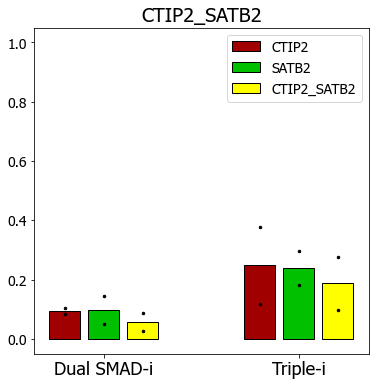

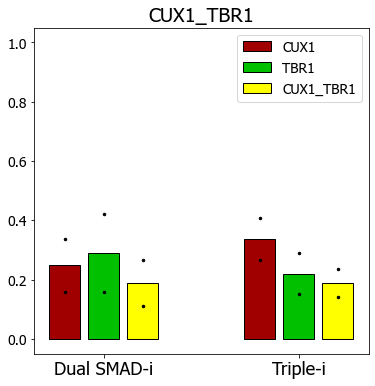

In [135]:
# 1. make aggregate SBNX, SBN, NT box plots
# 2. plot bar plots for cells in mistaken and non-rosettes

colors_full = [(160/255.,0,0),(0,192/255.,0),(255/255.,255/255.,0)]

for genes in [['CTIP2','SATB2'],['CUX1','TBR1']]:
    
    # first plot rosettes
    experiment = '_'.join(sorted(genes))
    df_sub = agg_df[(agg_df['experiment'] == experiment) & (agg_df['type'] == 'rosette')]
    vals = []
    positions = []
    colors = []
    pos_iter = 0
    
    for j,tx in enumerate(['Dual SMAD-i','Triple-i']):
        
        df_sub_exp = df_sub[df_sub['protocol']==tx]
        for k,gene in enumerate(genes):
            df_sub_exp_gene = df_sub_exp[df_sub_exp['gene']==gene]
            vals.append(list(df_sub_exp_gene['percent_pos']))
            positions.append(pos_iter)
            colors.append(colors_full[k])
            pos_iter += 1
            
        gene_combo = genes[1]+"_"+genes[0]
        df_sub_exp_gene = df_sub_exp[df_sub_exp['gene']==gene_combo]
        vals.append(list(df_sub_exp_gene['percent_pos']))
        positions.append(pos_iter)
        colors.append(colors_full[k+1])
        pos_iter += 1
        # double and triple combos
        pos_iter+=1
    
    
    fig = plt.figure(figsize=(6,6))
    ## second plot non-rosettes
    ax = plt.subplot(111)
    experiment = '_'.join(sorted(genes))
    df_sub = agg_df[(agg_df['experiment'] == experiment) & (agg_df['type']!='rosette')]
    pos_iter = 0
    for j,tx in enumerate(['Dual SMAD-i','Triple-i']):
        
        df_sub_exp = df_sub[df_sub['protocol']==tx]
        for k,gene in enumerate(genes):
            
            non_rosettes = list(df_sub_exp[(df_sub_exp['type']=='non-rosette') & (df_sub_exp['gene']==gene)]['percent_pos'])
            plt.bar(pos_iter,np.mean(non_rosettes),color=colors_full[k],edgecolor='black')
            plt.plot([pos_iter for ii in range(len(non_rosettes))],non_rosettes,'.',markersize=5,color='black',
                 zorder=2,alpha=1)#markerfacecolor='none',
            pos_iter += 1
            
        gene_combo = genes[1]+"_"+genes[0]
        
        non_rosettes = list(df_sub_exp[(df_sub_exp['type']=='non-rosette') & (df_sub_exp['gene']==gene_combo)]['percent_pos'])
        plt.bar(pos_iter,np.mean(non_rosettes),color=colors_full[k+1],edgecolor='black')
        plt.plot([pos_iter for ii in range(len(non_rosettes))],non_rosettes,'.',markersize=5,color='black',
             zorder=2,alpha=1)#markerfacecolor='none',
        pos_iter += 1
        
        df_sub_exp_gene = df_sub_exp[df_sub_exp['gene']==gene_combo]
        vals.append(list(df_sub_exp_gene['percent_pos']))
        positions.append(pos_iter)
        colors.append(colors_full[k+1])
        pos_iter += 1
        # double and triple combos
        pos_iter+=1
    

    plt.title('_'.join(genes),fontsize=20)
    plt.ylim(-0.05,1.05)
    plt.xlim(plt.xlim())
    for k,gene in enumerate(genes):
        plt.bar(-10,0,color=colors_full[k],label=gene,edgecolor='black')
    plt.bar(-10,0,color=colors_full[k+1],label=genes[0]+"_"+genes[1],edgecolor='black')
    plt.legend(fontsize=14)
    plt.xticks([1,6],['Dual SMAD-i','Triple-i'],fontsize=18)
    plt.yticks(fontsize=14)
    plt.show()
    
    plt.show()

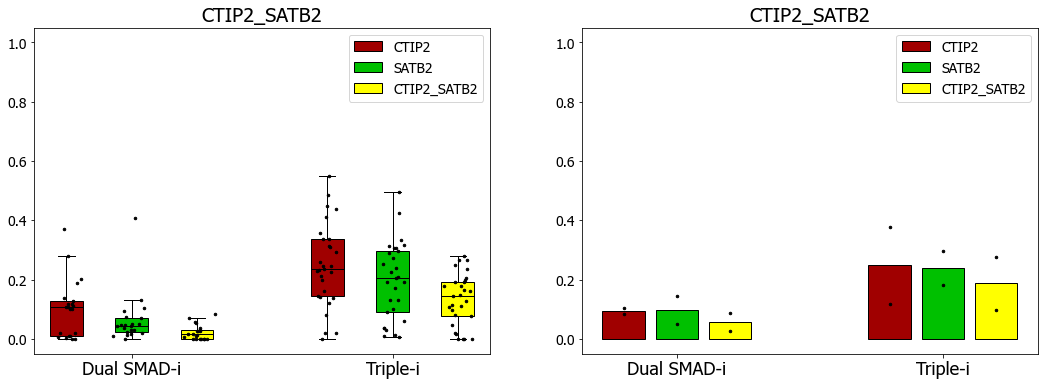

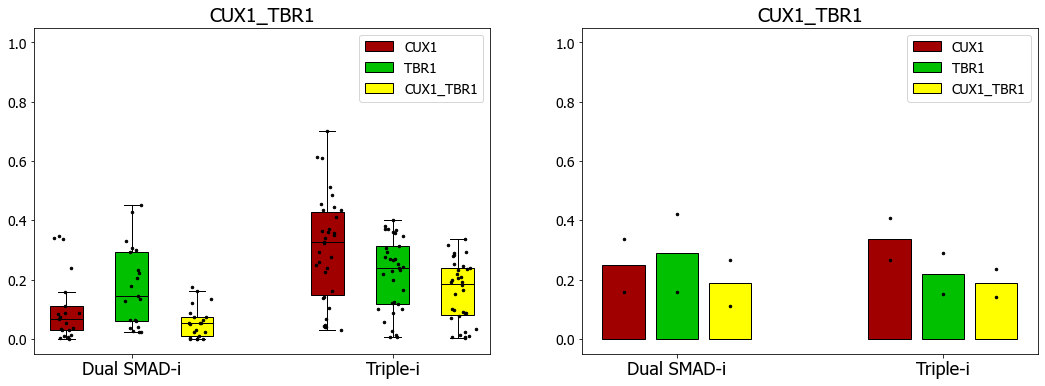

In [131]:
# 1. make aggregate SBNX, SBN, NT box plots
# 2. plot bar plots for cells in mistaken and non-rosettes

colors_full = [(160/255.,0,0),(0,192/255.,0),(255/255.,255/255.,0)]

for genes in [['CTIP2','SATB2'],['CUX1','TBR1']]:
    
    # first plot rosettes
    experiment = '_'.join(sorted(genes))
    df_sub = agg_df[(agg_df['experiment'] == experiment) & (agg_df['type'] == 'rosette')]
    vals = []
    positions = []
    colors = []
    pos_iter = 0
    
    for j,tx in enumerate(['Dual SMAD-i','Triple-i']):
        
        df_sub_exp = df_sub[df_sub['protocol']==tx]
        for k,gene in enumerate(genes):
            df_sub_exp_gene = df_sub_exp[df_sub_exp['gene']==gene]
            vals.append(list(df_sub_exp_gene['percent_pos']))
            positions.append(pos_iter)
            colors.append(colors_full[k])
            pos_iter += 1
            
        gene_combo = genes[1]+"_"+genes[0]
        df_sub_exp_gene = df_sub_exp[df_sub_exp['gene']==gene_combo]
        vals.append(list(df_sub_exp_gene['percent_pos']))
        positions.append(pos_iter)
        colors.append(colors_full[k+1])
        pos_iter += 1
        # double and triple combos
        pos_iter+=1
    
    
    fig = plt.figure(figsize=(18,6))
    ax = plt.subplot(121)

    bp = ax.boxplot(vals,positions=positions,showfliers=False,vert=True, patch_artist=True,zorder=1)
    for j,patch in enumerate(bp['boxes']):
        patch.set_facecolor(color=colors[j])
    for j,whisker in enumerate(bp['whiskers']):
        whisker.set(color='black', linewidth=1)
    for j,cap in enumerate(bp['caps']):
        cap.set(color='black', linewidth=1)
    for j,median in enumerate(bp['means']):
        median.set(color='black', linewidth=1)
    for j,median in enumerate(bp['medians']):
        median.set(color='black', linewidth=1)

    for val,pos,col in zip(vals,positions,colors):
        plt.plot([pos]*len(val)+np.random.randn(len(val))*0.1,val,'.',markersize=5,color='black',
                 zorder=2,alpha=1)#markerfacecolor='none',
    
    plt.title('_'.join(genes),fontsize=20)
    plt.ylim(-0.05,1.05)
    plt.xlim(plt.xlim())
    for k,gene in enumerate(genes):
        plt.bar(-10,0,color=colors_full[k],label=gene,edgecolor='black')
    plt.bar(-10,0,color=colors_full[k+1],label=genes[0]+"_"+genes[1],edgecolor='black')
    plt.legend(fontsize=14)
    plt.xticks([1,5],['Dual SMAD-i','Triple-i'],fontsize=18)
    plt.yticks(fontsize=14)
    
    
    ## second plot non-rosettes
    ax = plt.subplot(122)
    experiment = '_'.join(sorted(genes))
    df_sub = agg_df[(agg_df['experiment'] == experiment) & (agg_df['type']!='rosette')]
    pos_iter = 0
    for j,tx in enumerate(['Dual SMAD-i','Triple-i']):
        
        df_sub_exp = df_sub[df_sub['protocol']==tx]
        for k,gene in enumerate(genes):
            
            non_rosettes = list(df_sub_exp[(df_sub_exp['type']=='non-rosette') & (df_sub_exp['gene']==gene)]['percent_pos'])
            plt.bar(pos_iter,np.mean(non_rosettes),color=colors_full[k],edgecolor='black')
            plt.plot([pos_iter for ii in range(len(non_rosettes))],non_rosettes,'.',markersize=5,color='black',
                 zorder=2,alpha=1)#markerfacecolor='none',
            pos_iter += 1
            
        gene_combo = genes[1]+"_"+genes[0]
        
        non_rosettes = list(df_sub_exp[(df_sub_exp['type']=='non-rosette') & (df_sub_exp['gene']==gene_combo)]['percent_pos'])
        plt.bar(pos_iter,np.mean(non_rosettes),color=colors_full[k+1],edgecolor='black')
        plt.plot([pos_iter for ii in range(len(non_rosettes))],non_rosettes,'.',markersize=5,color='black',
             zorder=2,alpha=1)#markerfacecolor='none',
        pos_iter += 1
        
        df_sub_exp_gene = df_sub_exp[df_sub_exp['gene']==gene_combo]
        vals.append(list(df_sub_exp_gene['percent_pos']))
        positions.append(pos_iter)
        colors.append(colors_full[k+1])
        pos_iter += 1
        # double and triple combos
        pos_iter+=1
    

    plt.title('_'.join(genes),fontsize=20)
    plt.ylim(-0.05,1.05)
    plt.xlim(plt.xlim())
    for k,gene in enumerate(genes):
        plt.bar(-10,0,color=colors_full[k],label=gene,edgecolor='black')
    plt.bar(-10,0,color=colors_full[k+1],label=genes[0]+"_"+genes[1],edgecolor='black')
    plt.legend(fontsize=14)
    plt.xticks([1,6],['Dual SMAD-i','Triple-i'],fontsize=18)
    plt.yticks(fontsize=14)
    plt.show()
    
    plt.show()